In [ ]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing

from statsmodels.sandbox.stats.multicomp import multipletests as MCP
import nibabel as nib
from nilearn import plotting

from joblib import Parallel, delayed

import pymer4
from pymer4.models import Lmer
import itertools

from scipy.stats import ttest_ind, chi2_contingency 

import glob

from mne.viz import plot_connectivity_circle, circular_layout
from psmpy import PsmPy

os.environ['KMP_DUPLICATE_LIB_OK']='True'

pymer4.__version__

'0.7.5'

In [ ]:
# We will use Linear-Mixed Effect Models with random effects for testing group differences in derived rsfMRI features

In [4]:
def merge_bool_masks(*masks):
    
    return np.array([all(tup) for tup in zip(*masks)])


def has_N_samples_per_class(covariates_df, class_label, subject_mask=None, N_threshold=10, verbose=True):
    
    groups = np.array(covariates_df.site_id.values)
    
    if subject_mask is not None:
        tmp_df = covariates_df.loc[subject_mask, ['ID', class_label, 'Age', 'Sex', 'site_id']]
    else:
        tmp_df = covariates_df.loc[:, ['ID', class_label, 'Age', 'Sex', 'site_id']]
    
    all_sites = np.unique(tmp_df.site_id)
    unique_class_values = sorted(np.unique(tmp_df[class_label]))
    assert len(unique_class_values) == 2

    # Store number of included subjects per class and site in Dataframe
    counts_df = tmp_df.groupby(['site_id', class_label]).size()
    counts_df = pd.DataFrame(counts_df)
    counts_df = counts_df.reset_index()
    counts_df = counts_df.pivot(index='site_id', columns=class_label)
    counts_df.columns = counts_df.columns.droplevel(0)
    counts_df.columns.name = None
    counts_df = counts_df.reset_index()

    included_sites = counts_df.loc[(counts_df[unique_class_values[0]] >= N_threshold) & 
                                   (counts_df[unique_class_values[1]] >= N_threshold)]['site_id'].values
    excluded_sites = list(set(all_sites).difference(included_sites))
    
    counts_df = counts_df.loc[counts_df.site_id.isin(included_sites)]

    site_mask = [g not in excluded_sites for g in groups]
    
    if verbose:
        N_excluded = len(tmp_df.loc[tmp_df.site_id.isin(excluded_sites)])
        print("Excluded {} subjects belonging to {} different sites:\n\n{}".format(N_excluded, 
                                                                                   len(excluded_sites), 
                                                                                   '\n'.join(excluded_sites)))
    return site_mask, counts_df
    

def ensure_folder(folder_dir):
    if not os.path.exists(folder_dir):
        os.makedirs(folder_dir)

In [5]:
# Functions for LME statistics

# Repeatability/ICC value required for effect stat
def mixeff_R(var_between, var_within):
    R = var_between / (var_between + var_within) # R for d and r (eq23)
    return R


# Effect size d (specific for lm with random effects (eq22)
def mixeff_d(t_value, N_groups, N_observations, n_group1, n_group2, R, k): # k = number of paramters
    d = ( (t_value*(1+(N_groups/N_observations)*R) * (np.sqrt(1-R) * N_observations)) / 
          (np.sqrt(n_group1*n_group2)*np.sqrt(N_observations-k)) )
    return d


# Standard error for Cohens d (eq16)"
def se_for_d(d, n_group1, n_group2):
    return np.sqrt(((n_group1+n_group2-1)/(n_group1+n_group2-3))*(4/(n_group1+n_group2))*(1+((d**2)/8)))


# Compute confidence intervals
def CI(d, se_d):
    ci_lower = d - (se_d * 1.96)
    ci_upper = d + (se_d * 1.96)
    return ci_lower, ci_upper

In [6]:
def run_LME_model(subject_mask, feature_vec, X_label, X_vec, Age_vec, Sex_vec, groups_vec, FD_vec):
                
    # Fixed factor of interest (i.e. Dx, Med, AO or Severity) should be a binary factor
    assert np.all(np.unique(X_vec[subject_mask]) == [0, 1])
    factors={X_label : ["0","1"]}

    # Create dataFrame that includes all variables used to fit LME model
    data_df = pd.DataFrame(data={'feature_vec': feature_vec,
                                  X_label: X_vec,
                                 'Age': Age_vec,
                                 'Sex': Sex_vec,
                                 'Site_ID': groups_vec,
                                 'mean_FD': FD_vec,
                                  })

    # Apply subject masking
    data_df = data_df.loc[subject_mask, :]
    data_df[X_label] = data_df[X_label].astype(int)
    
    # Ensure there are no missing values
    assert ~np.any(data_df.isna())

    # Run LME model with random intercept for Site_ID
    model = Lmer("feature_vec ~ " + X_label +  " + Age + Sex + mean_FD + (1 | Site_ID)", data=data_df)
    model.fit(REML=True, factors=factors)

    # LME statistics for fixed factor of interest now have suffix of highest factor detected (i.e. '1') 
    # This means LME statistics are estimated for difference between factor 1 - factor 0
    LME_X_label = X_label + '1'

    # Extract T and p-value for factor of interest
    t_value = model.coefs['T-stat'][LME_X_label]
    p_value = model.coefs['P-val'][LME_X_label]

    # Extract intercept (random effect-stat) variance and residual variance 
    R_between = model.ranef_var.Var['Site_ID']
    R_within = model.ranef_var.Var['Residual'] 

    N_groups = int(model.grps['Site_ID'])
    N_observations = model.data.shape[0]
    n_group0 = sum(data_df[X_label] == 0)
    n_group1 = sum(data_df[X_label] == 1)

    # Number of fixed factor parameters including intercept
    k = model.coefs.shape[0]

    # Extract estimated coefficient and its standard error
    est_B = model.coefs.Estimate[LME_X_label]
    se_est_B = model.coefs.SE[LME_X_label]

    # Repeatability/ICC value required for effect size calculation
    R_calc = mixeff_R(R_between, R_within) 

    # Calculate effect size and standard error
    d = mixeff_d(t_value, N_groups, N_observations, n_group0, n_group1, R_calc, k)
    se_d = se_for_d(d, n_group0, n_group1)

    # Compute 95% confidence intervals
    ci_lower_d, ci_upper_d = CI(d, se_d)

    # Extract model goodness of fit estimations
    AIC = model.AIC 
    logLike = model.logLike

    # Extract marginal mean estimates for fixed factor of interest
    marginal_estimates, comparisons = model.post_hoc(marginal_vars=X_label)

    marg_mean_0 = marginal_estimates.loc[marginal_estimates[X_label] == '0'].Estimate.values[0]
    marg_mean_1 = marginal_estimates.loc[marginal_estimates[X_label] == '1'].Estimate.values[0]

    # And mean marginal difference (factor 1 - factor 0)
    marg_mean_diff = marg_mean_1 - marg_mean_0

    return marg_mean_1, marg_mean_0, marg_mean_diff, t_value, p_value, d, se_d, ci_lower_d, ci_upper_d, n_group0, n_group1, N_groups, AIC, logLike, est_B, se_est_B


In [8]:
# Functions for plotting results

def plot_clustermap(CC, vmin, vmax, network_labels, network_colors, network_lut, network_ordering_dict, mask, 
                    save_dir, filename):
        
    cmap='coolwarm'
    figsize=(10, 10)

    # NB for the row_colors to work, the CC must be placed in a pandas df
    g = sns.clustermap(pd.DataFrame(CC), cmap=cmap, mask=mask, 
                    row_colors=network_colors, col_colors=network_colors, vmin=vmin, vmax=vmax,
                    row_cluster=False, col_cluster=False, center=0, figsize=figsize)

    # Draw the legend bar for the classes
    for label in network_ordering_dict.keys():
        if label not in network_labels:
            continue
        g.ax_col_dendrogram.bar(0, 0, color=network_lut[label], label=label, linewidth=0)
        
    g.ax_col_dendrogram.legend(loc="center", ncol=6, bbox_to_anchor=(0.5, -4.5))

    # move the colorbar for correlation values
    g.cax.set_position([0.05, .2, .03, .45])

    # remove the ticks
    g.ax_heatmap.axis('off')

    # save images
    g.savefig(os.path.join(save_dir, filename + '.eps'), dpi=300)
    g.savefig(os.path.join(save_dir, filename + '.jpeg'), dpi=300)
    
        
def tril_vec_to_mat(vec, nROIs, fill_diag=1):
    
    tmp_matrix = np.zeros((nROIs, nROIs))
    idx_tril = np.tril_indices(nROIs, k=-1)
    
    tmp_matrix[idx_tril] = vec
    tmp_matrix += tmp_matrix.T
    np.fill_diagonal(tmp_matrix, fill_diag)
        
    return tmp_matrix
    
    
def plot_ROI_to_ROI_statistics(df, n_ROIs, network_labels, network_colors, 
                               network_lut, network_ordering_dict, save_dir):
    
    # Restructure statistics into correlation matrix
    d_mat = tril_vec_to_mat(df.d, n_ROIs, fill_diag=99)
    T_mat = tril_vec_to_mat(df.t_value, n_ROIs, fill_diag=99)
    p_uncorrected_mat = tril_vec_to_mat(df.p_value, n_ROIs, fill_diag=1)
    p_bonf_corrected_mat = tril_vec_to_mat(df.p_bonf_corrected, n_ROIs, fill_diag=1)
    p_FDR_corrected_mat = tril_vec_to_mat(df.p_FDR_corrected, n_ROIs, fill_diag=1)
    p_FWE_corrected_mat = tril_vec_to_mat(df.p_FWE_corrected, n_ROIs, fill_diag=1)

    # Create different thresholding masks
    unthresholded_mask = np.zeros_like(d_mat, dtype=bool)
    p_unc_thresh_mask = p_uncorrected_mat >= pthr
    p_bonf_thresh_mask = p_bonf_corrected_mat >= pthr
    p_FDR_thresh_mask = p_FDR_corrected_mat >= qFDR
    p_FWE_thresh_mask = p_FWE_corrected_mat >= pthr

    stats_to_plot = [
                     (unthresholded_mask, '_unthresh'),
                     (p_unc_thresh_mask, '_uncorr'),
                     (p_bonf_thresh_mask, '_Bonferroni'),
                     (p_FDR_thresh_mask, '_FDR'),
                     (p_FWE_thresh_mask, '_FWE')
                    ]
    
    # Only plot lower triangular of matrix
    for i in range(len(stats_to_plot)):
        stats_to_plot[i][0][np.triu_indices(n_ROIs)] = True

    # Save plots for P values with different thresholding
    p_res = [p_uncorrected_mat, p_uncorrected_mat, p_bonf_corrected_mat, p_FDR_corrected_mat, p_FWE_corrected_mat]

    # Save plots for Cohen's D values with different thresholding
    for mask, filename_suffix in stats_to_plot:
        plot_clustermap(d_mat, -0.5, 0.5, network_labels, network_colors, network_lut, network_ordering_dict, 
                        mask=mask, save_dir=save_dir, filename='LME_d' + filename_suffix)
    plt.close('all')

    # Save plots for T values with different thresholding
    for mask, filename_suffix in stats_to_plot:
        plot_clustermap(T_mat, -10, 10, network_labels, network_colors, network_lut, network_ordering_dict, 
                        mask=mask, save_dir=save_dir, filename='LME_T' + filename_suffix)
    plt.close('all')

    for i, (mask, filename_suffix) in enumerate(stats_to_plot):
        plot_clustermap(-np.log10(p_res[i]), 0, 10, network_labels, network_colors, network_lut, network_ordering_dict,
                        mask=mask, save_dir=save_dir, filename='LME_p' + filename_suffix)
    plt.close('all')
    
    
def plot_network_to_network_statistics(df, N_networks, between_network_labels, within_network_labels, 
                                       network_colors, network_lut, network_ordering_dict, save_dir):

    N_between_network_corrs = len(np.zeros((N_networks, N_networks))[np.tril_indices(N_networks, k=-1)])

    # Restructure statistics into correlation matrix, make sure to only use between network correlations for this
    d_mat = tril_vec_to_mat(df.d[:N_between_network_corrs], N_networks, fill_diag=99)
    T_mat = tril_vec_to_mat(df.t_value[:N_between_network_corrs], N_networks, fill_diag=99)
    p_uncorrected_mat = tril_vec_to_mat(df.p_value[:N_between_network_corrs], N_networks, fill_diag=1)
    p_bonf_corrected_mat = tril_vec_to_mat(df.p_bonf_corrected[:N_between_network_corrs], N_networks, fill_diag=1)
    p_FDR_corrected_mat = tril_vec_to_mat(df.p_FDR_corrected[:N_between_network_corrs], N_networks, fill_diag=1)
    p_FWE_corrected_mat = tril_vec_to_mat(df.p_FWE_corrected[:N_between_network_corrs], N_networks, fill_diag=1)

    # Now fill in diagonal with within network correlations
    within_network_mask = np.array([l in within_network_labels for l in between_network_labels])
    diag_idx = np.diag_indices(N_networks)
    diag_idx_ = diag_idx[0][within_network_mask], diag_idx[1][within_network_mask]
    diag_idx_rev = diag_idx[0][~within_network_mask], diag_idx[1][~within_network_mask]

    d_mat[diag_idx_] = df.d[N_between_network_corrs:]
    T_mat[diag_idx_] = df.t_value[N_between_network_corrs:]
    p_uncorrected_mat[diag_idx_] = df.p_value[N_between_network_corrs:]
    p_bonf_corrected_mat[diag_idx_] = df.p_bonf_corrected[N_between_network_corrs:]
    p_FDR_corrected_mat[diag_idx_] = df.p_FDR_corrected[N_between_network_corrs:]
    p_FWE_corrected_mat[diag_idx_] = df.p_FWE_corrected[N_between_network_corrs:]

    # Create different thresholding masks
    unthresholded_mask = np.zeros_like(d_mat, dtype=bool)
    p_unc_thresh_mask = p_uncorrected_mat >= pthr
    p_bonf_thresh_mask = p_bonf_corrected_mat >= pthr
    p_FDR_thresh_mask = p_FDR_corrected_mat >= qFDR
    p_FWE_thresh_mask = p_FWE_corrected_mat >= pthr

    stats_to_plot = [
                     (unthresholded_mask, '_unthresh'),
                     (p_unc_thresh_mask, '_uncorr'),
                     (p_bonf_thresh_mask, '_Bonferroni'),
                     (p_FDR_thresh_mask, '_FDR'),
                     (p_FWE_thresh_mask, '_FWE')
                    ]

    # Only plot lower triangular of matrix, this time including the diagonal
    for i in range(len(stats_to_plot)):
        stats_to_plot[i][0][np.triu_indices(N_networks, k=1)] = True 

        # Remove non-missing within-network correlations from masks
        stats_to_plot[i][0][diag_idx_rev] = True

    # Save plots for P values with different thresholding
    p_res = [p_uncorrected_mat, p_uncorrected_mat, p_bonf_corrected_mat, p_FDR_corrected_mat, p_FWE_corrected_mat]

    # Save plots for Cohen's D values with different thresholding
    for mask, filename_suffix in stats_to_plot:
        plot_clustermap(d_mat, -0.5, 0.5, network_labels, network_colors, network_lut, network_ordering_dict, 
                        mask=mask, save_dir=save_dir, filename='LME_d' + filename_suffix)
    plt.close('all')

    # Save plots for T values with different thresholding
    for mask, filename_suffix in stats_to_plot:
        plot_clustermap(T_mat, -10, 10, network_labels, network_colors, network_lut, network_ordering_dict, 
                        mask=mask, save_dir=save_dir, filename='LME_T' + filename_suffix)
    plt.close('all')

    for i, (mask, filename_suffix) in enumerate(stats_to_plot):
        plot_clustermap(-np.log10(p_res[i]), 0, 10, network_labels, network_colors, network_lut, network_ordering_dict,
                        mask=mask, save_dir=save_dir, filename='LME_p' + filename_suffix)
    plt.close('all')
    

In [9]:
def plot_vec_statistics(tmp_df, roi_labels, roi_network_labels, unique_network_labels, filtered_atlas_img,
                        save_dir, network_wise=False):
    
    df = tmp_df.copy(deep=True) # Make deep copy to ensure original LME df is not mutated

    d_vec = np.array(df.d.values)
    T_vec = np.array(df.t_value.values)
    p_uncorrected_vec = np.array(df.p_value.values)
    p_bonf_corrected = np.array(df.p_bonf_corrected.values)
    p_FDR_corrected = np.array(df.p_FDR_corrected.values)
    p_FWE_corrected = np.array(df.p_FWE_corrected.values)

    # Create different thresholding masks
    unthresholded_mask = np.zeros_like(d_vec, dtype=bool)
    p_unc_thresh_mask = p_uncorrected_vec >= pthr
    p_bonf_thresh_mask = p_bonf_corrected >= pthr
    p_FDR_thresh_mask = p_FDR_corrected >= qFDR
    p_FWE_thresh_mask = p_FWE_corrected >= pthr

    stats_to_plot = [
                     (unthresholded_mask, '_unthresh'),
                     (p_unc_thresh_mask, '_uncorr'),
                     (p_bonf_thresh_mask, '_Bonferroni'),
                     (p_FDR_thresh_mask, '_FDR'),
                     (p_FWE_thresh_mask, '_FWE')
                    ]

    # Save plots for Cohen's D values with different thresholding
    for mask, filename_suffix in stats_to_plot:
        plot_stat_map(stat_vec_og=d_vec, 
                      roi_labels=roi_labels, 
                      roi_network_labels=roi_network_labels, unique_network_labels=unique_network_labels,
                      filtered_atlas_img=filtered_atlas_img, mask=mask, 
                      save_dir=save_dir, filename='LME_d' + filename_suffix,
                      network_wise=network_wise)

    plt.close('all')

    # Save plots for T values with different thresholding
    for mask, filename_suffix in stats_to_plot:
        plot_stat_map(stat_vec_og=T_vec, 
                      roi_labels=roi_labels, 
                      roi_network_labels=roi_network_labels, unique_network_labels=unique_network_labels,
                      filtered_atlas_img=filtered_atlas_img, mask=mask, 
                      save_dir=save_dir, filename='LME_T' + filename_suffix,
                      network_wise=network_wise)

    plt.close('all')

    # Save plots for P values with different thresholding
    p_res = [p_uncorrected_vec, 
             p_uncorrected_vec, 
             p_bonf_corrected, 
             p_FDR_corrected, 
             p_FWE_corrected]

    for i, (mask, filename_suffix) in enumerate(stats_to_plot):
        plot_stat_map(stat_vec_og=-np.log10(p_res[i]), 
                      roi_labels=roi_labels, 
                      roi_network_labels=roi_network_labels, unique_network_labels=unique_network_labels,
                      filtered_atlas_img=filtered_atlas_img, mask=mask,
                      save_dir=save_dir, filename='LME_p' + filename_suffix,
                      network_wise=network_wise)

    plt.close('all')


def plot_stat_map(stat_vec_og, roi_labels, roi_network_labels, unique_network_labels, filtered_atlas_img,
                  mask, save_dir, filename, network_wise=False):

    stat_vec = stat_vec_og.copy()
    
    # Apply mask (where True == ROIs/networks that should be removed)
    stat_vec[mask] = 0
    if np.all(stat_vec == 0):
        print("No significant results, skipping plot")
        return
    
    # Make copy from filtered_atlas_img:
    affine = filtered_atlas_img.affine
    header = filtered_atlas_img.header
    atlas_img_data = filtered_atlas_img.get_fdata()

    stat_map_img_data = atlas_img_data.copy()
    stat_map_img_data[:] = 0 # Set all to zero 
    
    if network_wise:
        
        assert len(unique_network_labels) == len(stat_vec)
        
        # Iterate over unique network labels that are already matched to order of network-wise features
        for i, n in enumerate(unique_network_labels):

            network_mask = network_labels == n
            ROIs_in_network = roi_labels[network_mask]

            lut_rows = lut_df.loc[lut_df.Schaeffer_Yeon_labels.isin(ROIs_in_network)]
            assert len(lut_rows) == len(ROIs_in_network)

            network_roi_img_labels = lut_rows.roi_ID.values
            network_roi_img_mask = np.isin(atlas_img_data, network_roi_img_labels)
            
            assert np.sum(network_roi_img_mask) > 0

            stat_map_img_data[network_roi_img_mask] = stat_vec[i]
        
    else:
        
        assert len(roi_labels) == len(stat_vec)

        # Iterate over ROIs and fill Nifti image with corresponding statistic
        for i, l in enumerate(roi_labels):

            lut_row = lut_df.loc[lut_df.Schaeffer_Yeon_labels == l]
            assert len(lut_row) == 1

            roi_img_label = lut_row.roi_ID.values[0]
            roi_img_label_mask = atlas_img_data == roi_img_label
            
            assert np.sum(roi_img_label_mask) > 0

            stat_map_img_data[roi_img_label_mask] = stat_vec[i]
    

    # Save data to Nifti image
    stat_map_img = nib.Nifti1Image(stat_map_img_data, affine, header)

    # Store Nifti
    nib.save(stat_map_img, os.path.join(save_dir, filename + '.nii.gz'))

    # Create and save brain plots for statistics
    # Note: we do not mess with colorbars as NiLearn won't allow assymmetric ones!
    
    abs_max = np.abs(stat_map_img_data).max()
    vmax = np.round(np.ceil(float(abs_max)/.05) * 0.05, 2)
    
    cmap = 'coolwarm'
    fig1 = plt.figure(figsize=(10, 5), dpi=300)
    plotting.plot_stat_map(stat_map_img, threshold=0, cmap=cmap, figure=fig1, draw_cross=False, 
                           vmax=vmax,
                           output_file=os.path.join(save_dir, filename + '.pdf'))
    fig2 = plt.figure(figsize=(10, 5), dpi=300)
    plotting.plot_stat_map(stat_map_img, threshold=0, cmap=cmap, figure=fig2, draw_cross=False, 
                           vmax=vmax,
                           output_file=os.path.join(save_dir, filename + '.jpeg'))

In [10]:
# !!! Load most recent pooled data

pooled_data_main_dir = '/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Pooled_Data'
pooled_data_dirs = os.listdir('/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Pooled_Data')

if len(pooled_data_dirs) > 0:
    
    print("Loading most recent pooled data...")
    most_recent_idx = np.argmax([datetime.datetime.strptime(d, "%d_%m_%Y") for d in pooled_data_dirs])
    print("Found data stored @ {}".format(pooled_data_dirs[most_recent_idx]))
    pooled_data_dir = os.path.join(pooled_data_main_dir, pooled_data_dirs[most_recent_idx])
    pooled_data_path = os.path.join(pooled_data_dir, 'pooled_data.npz')
    
    data = np.load(pooled_data_path, allow_pickle=True)

    included_subject_ids=data['included_subject_ids']
    
    roi_labels=data['roi_labels']
    network_labels=data['network_labels']
    
    network_ordering_dict=data['network_ordering_dict'].item()

    fALFF_per_ROI=data['fALFF_per_ROI']
    fALFF_per_network=data['fALFF_per_network']

    reHo_per_ROI=data['reHo_per_ROI']
    reHo_per_network=data['reHo_per_network']

    CC_matrix=data['CC_matrix']

    within_network_correlations=data['within_network_correlations']
    within_network_correlations_labels=data['within_network_correlations_labels']

    between_network_correlations=data['between_network_correlations']
    between_network_correlations_labels=data['between_network_correlations_labels']

    filtered_atlas_img = nib.load(os.path.join(pooled_data_dir, 'included_regions_atlas.nii.gz'))
    lut_df = pd.read_csv(os.path.join(pooled_data_dir, 'Schaefer2018_400Parcels_17Networks_LUT.csv'))

    included_subjects_derivates_df = pd.read_csv(os.path.join(pooled_data_dir, 
                                                              'included_subjects_derivates.csv'))
    included_subjects_covariates_df = pd.read_csv(os.path.join(pooled_data_dir, 
                                                               'included_subjects_covariates.csv'))

    N_subjects = included_subjects_derivates_df.shape[0]
    N_sites = len(included_subjects_derivates_df.site_id.unique())

    print("Loaded pooled data for {} subjects from {} sites...".format(N_subjects, N_sites))

    print("Done!")


Loading most recent pooled data...
Found data stored @ 01_03_2022
Loaded pooled data for 2148 subjects from 33 sites...
Done!


In [11]:
for site_id in np.unique(included_subjects_derivates_df.site_id):
    age_samples = included_subjects_covariates_df.loc[included_subjects_derivates_df.site_id == site_id].Age_Sample_WBB
    print(site_id, np.unique(age_samples))

Amsterdam_AMC [3.]
Amsterdam_VUmc [3.]
Bangalore_NIMHANS [2. 3.]
Barcelona_Bellvitge/ANTIGA_1.5T [3.]
Barcelona_Bellvitge/COMPULSE_3T [3.]
Barcelona_Bellvitge/PROV_1.5T [3.]
Barcelona_HCPB [1. 2. 3.]
Bergen [3.]
Braga_UMinho/Braga_1.5T [3.]
Braga_UMinho/Braga_1.5T_act [3.]
Braga_UMinho/Braga_3T [2. 3.]
Brazil [2. 3.]
Cape_Town_UCT/Skyra [3.]
Chiba/CHB [3.]
Chiba/CHBC [1. 2.]
Chiba/CHBSRPB [3.]
Dresden [1. 2. 3.]
Kyoto_KPU/Kyoto1.5T [3.]
Kyoto_KPU/Kyoto3T [3.]
Kyushu [2. 3.]
Milan_HSR [3.]
NYSPI_Columbia/Adults [3.]
NYSPI_Columbia/Pediatric [1. 2. 3.]
New_York [3.]
Seoul_SNU [2. 3.]
Shanghai_SMCH [2. 3.]
UCLA/Adult [3.]
Vancouver_BCCHR [1. 2. 3.]
Yale_Gruner [1. 2.]
Yale_Pittinger/HCP_Prisma [3.]
Yale_Pittinger/HCP_Trio [3.]
Yale_Pittinger/Yale_2014 [3.]
Zurich_UCH [2. 3.]


In [12]:
n_ROIs = len(roi_labels)

assert n_ROIs == CC_matrix.shape[-1]

print(n_ROIs)

318


In [13]:
unique_network_labels = []

for label in network_ordering_dict.keys():
    if label not in network_labels:
        continue
    else:
        unique_network_labels.append(label)
        
N_networks = len(unique_network_labels)

assert N_networks == len(np.unique(network_labels))
assert N_networks == reHo_per_network.shape[-1]
assert N_networks == fALFF_per_network.shape[-1]
assert np.all(unique_network_labels == between_network_correlations_labels)

print(N_networks)

18


In [14]:
# Unravel pair-wise ROI-to-ROI FC as 1d features.

# For a matrix of size n x n, the number of elements in the lower triangle is
print(CC_matrix.shape[-1] * (CC_matrix.shape[-1] - 1) / 2)

# Create mask for lower triangular of corremation matrix. Skip diagonal (auto) correlations.
tril_mask = np.tril(np.ones(CC_matrix.shape[-2:]), k=-1).astype(bool)
print(np.sum(tril_mask))

# Make sure IDs are matched so we can extract diagnosis and other covariates easily
assert np.all(included_subjects_derivates_df.site_subject_ID.values == included_subject_ids)
assert np.all(included_subjects_covariates_df.site_subject_ID.values == included_subject_ids)
assert np.all(included_subjects_derivates_df.site_subject_ID.values == 
              included_subjects_covariates_df.site_subject_ID.values)

# Take lower triangular of FC matrix
pairwise_ROI_to_ROI_FC_vec = CC_matrix[..., tril_mask]

print(pairwise_ROI_to_ROI_FC_vec.shape)

50403.0
50403
(2148, 50403)


In [15]:
assert np.all(included_subjects_derivates_df.site_id.values ==  included_subjects_covariates_df.site_id.values)

In [16]:
# We can choose to investigate within and between network FC separately, or combined
# We will combine them.

print(between_network_correlations.shape)

# Unravel pair-wise between-network FC correlations as 1d features. Skip diagonal!
tril_mask = np.tril(np.ones(between_network_correlations.shape[-2:]), k=-1).astype(bool)
pairwise_between_network_FC_vec = between_network_correlations[..., tril_mask]

print(pairwise_between_network_FC_vec.shape)

# Within-network FC correlations are already 1 features
print(within_network_correlations.shape)

# Combine between- and within network correlation vectors
pairwise_network_FC_vec = np.c_[pairwise_between_network_FC_vec, within_network_correlations]
print(pairwise_network_FC_vec.shape)

(2148, 18, 18)
(2148, 153)
(2148, 16)
(2148, 169)


In [17]:
# Confirm that all subjects included so far have diagnosis status

print(np.unique(included_subjects_covariates_df.Diagnosis))
assert sum(included_subjects_covariates_df.Diagnosis.isna()) == 0

[1. 2.]


In [18]:
# Extract Diagnosis status, and Sex & Age covariates

# "Diagnosis" recoded from (OCD=1, HC=2) to (OCD=1, HC=0)
Dx_vec = np.array(included_subjects_covariates_df.Diagnosis.replace(2, 0).values, dtype=int)

# "Sex" recoded from (1=male, 2=female) to (1=male, 0=female)
Sex_vec = np.array(included_subjects_covariates_df.Sex.replace(2, 0).values, dtype=int)

# "Age" # NOT scaled by / 100
Age_vec = np.array(included_subjects_covariates_df.Age)

# Site IDs
groups_vec = np.array(included_subjects_derivates_df.site_id.values)

# There are subjects missing either Sex, Age, Years of Education and/or all
IDs_missing_Sex = included_subjects_covariates_df.loc[
                                    (included_subjects_covariates_df.Sex.isna())].site_subject_ID.values

IDs_missing_Age = included_subjects_covariates_df.loc[
                                    (included_subjects_covariates_df.Age.isna())].site_subject_ID.values

IDs_missing_age_and_sex_covars = set(IDs_missing_Age).union(IDs_missing_Sex)

print("{} subjects miss Sex covariate".format(len(IDs_missing_Sex)))
print("{} subjects miss Age covariate".format(len(IDs_missing_Age)))
print("{} subjects miss ALL covariates".format(len(IDs_missing_age_and_sex_covars)))

0 subjects miss Sex covariate
0 subjects miss Age covariate
0 subjects miss ALL covariates


In [37]:
IDs_missing_FD = included_subjects_derivates_df.loc[
                                    (included_subjects_derivates_df.fd_mean.isna(
                                    ))].site_subject_ID.values

FD_vec = np.array(included_subjects_derivates_df.fd_mean.values)
print(IDs_missing_FD)

[]


In [20]:
# Extract info for sensitivity analyses: medication status, age of onset, years of education, severity

# "Medication status at time of scan  (1=naive, 2=unmedicated, 3=medicated)

is_unmed_pt = ((included_subjects_covariates_df.Medication_status.isin([1, 2])) & 
               (included_subjects_covariates_df.Diagnosis == 1))

is_med_pt = ((included_subjects_covariates_df.Medication_status.isin([3])) & 
             (included_subjects_covariates_df.Diagnosis == 1))

is_unmed_hc = ((included_subjects_covariates_df.Medication_status.isin([1, 2])) & 
               (included_subjects_covariates_df.Diagnosis == 2))

is_med_hc = (included_subjects_covariates_df.Medication_status.isin([3]) & 
            (included_subjects_covariates_df.Diagnosis == 2))

# Specific for unmedicated OCD vs HC or medicated OCD vs HC
is_med_pt_or_unmed_hc_mask = is_med_pt | is_unmed_hc 
is_unmed_pt_or_unmed_hc_mask = is_unmed_pt | is_unmed_hc

medication_groups_masks_dict = {
                                 'unmed_pt': is_unmed_pt,
                                 'med_pt': is_med_pt,
                                 'unmed_hc': is_unmed_hc,
                                 'med_hc': is_med_hc
                                }

medication_groups = list(medication_groups_masks_dict.keys())

for medication_group in medication_groups:
    print("N {} samples: {}".format(medication_group, sum(medication_groups_masks_dict[medication_group])))
    
Dx_med_filter_dict = {
                      'Med_OCD_Unmed_HC' : is_med_pt_or_unmed_hc_mask,
                      'Unmed_OCD_Unmed_HC' : is_unmed_pt_or_unmed_hc_mask
                      }

Dx_med_filter_labels = list(Dx_med_filter_dict.keys())

for Dx_med_filter in Dx_med_filter_labels:
    print("N {} samples: {}".format(Dx_med_filter, sum(Dx_med_filter_dict[Dx_med_filter])))

N unmed_pt samples: 555
N med_pt samples: 528
N unmed_hc samples: 748
N med_hc samples: 0
N Med_OCD_Unmed_HC samples: 1276
N Unmed_OCD_Unmed_HC samples: 1303


In [21]:
# Define median severity for patients

median_sev = included_subjects_covariates_df.loc[(~included_subjects_covariates_df['Y-BOCS'].isna()) &
                                                 (included_subjects_covariates_df.Diagnosis == 1)]\
                                                ['Y-BOCS'].median()
print(median_sev)


# Previously for structural ENIGMA-OCD we defined severity splits with median 24:
# (YBOCS <= 24; mild-moderate) and high severity (YBOCS > 24; moderate-severe) OCD;
# y = np.array(y > 24, dtype=int)

# Now we use YBOCS <= 25 (mild-moderate) and > 25 (moderate-severe)
is_low_sev_pt = ((included_subjects_covariates_df['Y-BOCS'] <= median_sev) & 
                 (included_subjects_covariates_df.Diagnosis == 1))
is_high_sev_pt = ((included_subjects_covariates_df['Y-BOCS'] > median_sev) & 
                  (included_subjects_covariates_df.Diagnosis == 1))

sev_groups_masks_dict = {
                         'low_sev_pt': is_low_sev_pt,
                         'high_sev_pt': is_high_sev_pt
                        }

sev_groups = list(sev_groups_masks_dict.keys())

for sev_group in sev_groups:
    print("N {} samples: {}".format(sev_group, sum(sev_groups_masks_dict[sev_group])))
    
# Only want to look into high/low sevety patients vs unmedicated subjects!
is_low_sev_pt_or_unmed_hc_mask = is_low_sev_pt | is_unmed_hc 
is_high_sev_pt_or_unmed_hc_mask = is_high_sev_pt | is_unmed_hc
    
Dx_sev_filter_dict = {
                      'Low_Sev_OCD_Unmed_HC' : is_low_sev_pt_or_unmed_hc_mask,
                      'High_Sev_OCD_Unmed_HC' : is_high_sev_pt_or_unmed_hc_mask
                      }

Dx_sev_filter_labels = list(Dx_sev_filter_dict.keys())

for Dx_sev_filter in Dx_sev_filter_labels:
    print("N {} samples: {}".format(Dx_sev_filter, sum(Dx_sev_filter_dict[Dx_sev_filter])))

25.0
N low_sev_pt samples: 579
N high_sev_pt samples: 494
N Low_Sev_OCD_Unmed_HC samples: 1327
N High_Sev_OCD_Unmed_HC samples: 1242


In [23]:
# Define masks for early and late onset OCD:

# Early-onset OCD patients / children (onset before age 18) to controls
# Late-onset OCD patients / adult (onset at age 18 or older)

# Consistent with previous ENIGMA-OCD analyses, I used y = np.array(y >= 18, dtype=int) for structural

# Now we only have coding for 1 or 2 (1=Child-onset, 2=Adult-onset, N/A)

is_early_AO_pt = ((included_subjects_covariates_df.Age_of_onset == 1) & 
                  (included_subjects_covariates_df.Diagnosis == 1))
is_late_AO_pt = ((included_subjects_covariates_df.Age_of_onset == 2) & 
                 (included_subjects_covariates_df.Diagnosis == 1))

AO_groups_masks_dict = {
                        'early_AO_pt': is_early_AO_pt,
                        'late_AO_pt': is_late_AO_pt
                        }

AO_groups = list(AO_groups_masks_dict.keys())

for AO_group in AO_groups:
    print("N {} samples: {}".format(AO_group, sum(AO_groups_masks_dict[AO_group])))
    
    
# Only want to look into high/low sevety patients vs unmedicated subjects!
is_early_AO_pt_or_unmed_hc_mask = is_early_AO_pt | is_unmed_hc 
is_late_AO_pt_or_unmed_hc_mask = is_late_AO_pt | is_unmed_hc
    
Dx_AO_filter_dict = {
                      'Early_AO_OCD_Unmed_HC' : is_early_AO_pt_or_unmed_hc_mask,
                      'Late_AO_OCD_Unmed_HC' : is_late_AO_pt_or_unmed_hc_mask
                      }

Dx_AO_filter_labels = list(Dx_AO_filter_dict.keys())

for Dx_AO_filter in Dx_AO_filter_labels:
    print("N {} samples: {}".format(Dx_AO_filter, sum(Dx_AO_filter_dict[Dx_AO_filter])))

N early_AO_pt samples: 492
N late_AO_pt samples: 478
N Early_AO_OCD_Unmed_HC samples: 1240
N Late_AO_OCD_Unmed_HC samples: 1226


In [24]:
# Define masks for specific age groups

is_pediatric_mask = included_subjects_covariates_df.Age_Sample_WBB.isin([1]).values
is_adolescent_mask = included_subjects_covariates_df.Age_Sample_WBB.isin([2]).values
is_adult_mask = included_subjects_covariates_df.Age_Sample_WBB.isin([3]).values
is_pooled_mask = np.ones_like(is_adult_mask, dtype=bool) 
is_pediatric_or_adolescent_mask = is_pediatric_mask | is_adolescent_mask # We will use this for pediatric analyses

# Create dict so we can access masks easily
age_groups = ['pooled', 'adult', 'pediatric']
age_group_masks_dict = dict(zip(age_groups, [is_pooled_mask, is_adult_mask, is_pediatric_or_adolescent_mask]))

for age_group in age_groups:
    print("N {} samples: {}".format(age_group, sum(age_group_masks_dict[age_group])))

N pooled samples: 2148
N adult samples: 1897
N pediatric samples: 251


In [25]:
included_subjects_covariates_df.loc[is_pediatric_or_adolescent_mask].Age.max()

17.92

In [26]:
print(sum(is_pediatric_mask), sum(is_adolescent_mask), sum(is_adult_mask))

37 214 1897


In [27]:
# Extract color palette for networks

grouped_lut = lut_df.groupby('Schaeffer_Yeon_17_networks')[['R','G','B']].mean()
network_color_lut = dict(zip(grouped_lut.index.values, zip(grouped_lut.R, grouped_lut.G, grouped_lut.B)))
network_color_lut

{'Cerebellum': (0.390625, 0.1953125, 0.0),
 'ContA': (0.9083345833333336, 0.5805533333333334, 0.14166625000000008),
 'ContB': (0.5396079999999999, 0.1954528, 0.2992944),
 'ContC': (0.4758166666666667, 0.5513066666666665, 0.7016333333333334),
 'DefaultA': (0.990425882352941, 0.9978094117647056, 0.013148785294117657),
 'DefaultB': (0.8109059374999995, 0.2448550000000001, 0.3164218749999998),
 'DefaultC': (0.00844646153846154, 0.0015083076923076923, 0.5191576923076922),
 'DorsAttnA': (0.2996370370370371, 0.6097274074074074, 0.24560629629629635),
 'DorsAttnB': (0.009411840000000003, 0.4638475999999999, 0.06541179999999996),
 'LimbicA': (0.869986923076923, 0.97255, 0.6527907692307693),
 'LimbicB': (0.4869881818181818, 0.5294100000000002, 0.2064163636363636),
 'SalVentAttnA': (0.7728950000000004, 0.22168264705882362, 0.9813149999999996),
 'SalVentAttnB': (0.9896182352941176, 0.5967717647058822, 0.8447535294117648),
 'SomMotA': (0.28255615384615407, 0.5125197435897438, 0.7095020512820512),
 '

In [28]:
# Extract correct Network colors for included ROI-to-ROI FC networks, and network-to-network FC networks

roi_FC_network_colors = [network_color_lut[l] for l in network_labels]
network_FC_network_colors = [network_color_lut[l] for l in between_network_correlations_labels]

In [ ]:
# P-value alpha for FDR - MCP correction

# We have 3 "MAIN" families, namely Functional Connectivity, fALFF and reHO.
# Within each feature set/family we run separate analyses for the following (sub-)samples:

# 1. Main analysis: OCD vs HC (pooled age groups)
# 2. per Age Group: pediatric OCD vs HC
# 3. per Age Group: adult OCD vs HC
# 4. Unmedicated OCD vs HC (only on pooled age groups)
# 5. Medicated OCD vs HC (only on pooled age groups)
# 6. Unmedicated vs Medicated OCD (only on pooled age groups)
# 7. Low Severity OCD vs HC (only on pooled age groups)
# 8. High Severity OCD vs HC (only on pooled age groups)
# 9. Low vs High Severity OCD (only on pooled age groups)
# 10. Early Onset OCD vs HC (only on pooled age groups)
# 11. Late Onset OCD vs HC (only on pooled age groups)
# 12. Early vs Late Onset OCD (only on pooled age groups)

# Additionally, we also make a distinction between models with ROI-wise and Network-wise level features.
# Conclusion: within each MAIN family we have 12 (number of sub-samples) x 2 (ROI-wise/Network-wise)
# = 24 comparisons/sub families
# Within each of the 24 sub-families we perform MCP correction over ALL regions

In [30]:
N_comparisons = 12 * 2

In [31]:
pthr = 0.05 / N_comparisons
qFDR = 0.05 / N_comparisons 
print(pthr, qFDR)

0.0020833333333333333 0.0020833333333333333


In [32]:
# Create dict that maps feature labels with data

feature_sets_dict = {
                     'ROI-to-ROI-FC': pairwise_ROI_to_ROI_FC_vec,
                     'network-FC': pairwise_network_FC_vec,
                     'reHo-ROI': reHo_per_ROI,
                     'reHo-network': reHo_per_network,
                     'fALFF-ROI': fALFF_per_ROI,
                     'fALFF-network': fALFF_per_network
                     }

feature_labels = list(feature_sets_dict.keys())
for feature_label in feature_labels:
    print("{} features shape: {}".format(feature_label, feature_sets_dict[feature_label].shape))

ROI-to-ROI-FC features shape: (2148, 50403)
network-FC features shape: (2148, 169)
reHo-ROI features shape: (2148, 318)
reHo-network features shape: (2148, 18)
fALFF-ROI features shape: (2148, 318)
fALFF-network features shape: (2148, 18)


## Run mass univariate statistics with LME ##

In [33]:
UNIVARIATE_RESULTS_DIR = os.path.join(pooled_data_dir, 'Results/Univariate_Analysis')
UNIVARIATE_RESULTS_DIR

'/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Pooled_Data/01_03_2022/Results/Univariate_Analysis'

### 1) Main analyses for group-differences between OCD and HC (Diagnosis) ###

In [124]:
class_label = 'Diagnosis'

tmp_covariates_df = included_subjects_covariates_df.copy()
if class_label not in tmp_covariates_df.columns:
    tmp_covariates_df[class_label] = vec_data
    
age_group_mask = age_group_masks_dict['pooled']
    
site_mask, counts_df = has_N_samples_per_class(tmp_covariates_df, class_label, age_group_mask, 
                                               N_threshold=10, verbose=True)
counts_df

Excluded 96 subjects belonging to 5 different sites:

Dresden
Barcelona_Bellvitge/COMPULSE_3T
Zurich_UCH
Kyushu
Amsterdam_AMC


site_id    1.0    2.0
1                    Amsterdam_VUmc   30.0   28.0
2                 Bangalore_NIMHANS  185.0  186.0
3   Barcelona_Bellvitge/ANTIGA_1.5T   48.0   79.0
5     Barcelona_Bellvitge/PROV_1.5T   41.0   20.0
6                    Barcelona_HCPB   36.0   27.0
7                            Bergen   29.0   25.0
8           Braga_UMinho/Braga_1.5T   28.0   18.0
9       Braga_UMinho/Braga_1.5T_act   44.0   53.0
10            Braga_UMinho/Braga_3T   32.0   26.0
11                           Brazil   59.0   34.0
12              Cape_Town_UCT/Skyra   23.0   15.0
13                        Chiba/CHB   16.0   27.0
14                       Chiba/CHBC   23.0   30.0
15                    Chiba/CHBSRPB   22.0   40.0
17              Kyoto_KPU/Kyoto1.5T   15.0   10.0
18                Kyoto_KPU/Kyoto3T   34.0   37.0
20                        Milan_HSR   10.0   56.0
21            NYSPI_Columbia/Adults   38.0   34.0
22         NYSPI_Columbia/Pediatric   21.0   14.0
23                         New_York   50.0   12.0
24                        Seoul_SNU   45.0   51.0
25                    Shanghai_SMCH   50.0   34.0
26                       UCLA/Adult   32.0   19.0
27                  Vancouver_BCCHR   22.0   24.0
28                      Yale_Gruner   10.0   15.0
29        Yale_Pittinger/HCP_Prisma   35.0   32.0
30          Yale_Pittinger/HCP_Trio   21.0   22.0
31         Yale_Pittinger/Yale_2014   25.0   60.0

In [138]:
RESULTS_DIR = os.path.join(UNIVARIATE_RESULTS_DIR, '1_Main_Analyses')

N_jobs = 20 

# Change these params depending on fixed factor of interest
title_template = '{}_CLF_{}_SAMPLES_{}_FEATURES'
class_label = 'Diagnosis'
vec_data = Dx_vec.copy()

# Iterate over all age groups and feature sets
for age_group, feature_label in itertools.product(age_groups, feature_labels):
    
    title = title_template.format(class_label, age_group, feature_label)
    print(title)
    
    save_dir = os.path.join(RESULTS_DIR, title)
    ensure_folder(save_dir)
    
    feature_set = feature_sets_dict[feature_label]
    i_features = np.arange(feature_set.shape[1])
    
    # Extract mask for given age_group (i.e. pooled, adult or pediatric)
    age_group_mask = age_group_masks_dict[age_group]
    
    # Create copy of covariates df and append class_label vec is this is not included aldy
    tmp_covariates_df = included_subjects_covariates_df.copy()
    if class_label not in tmp_covariates_df.columns:
        tmp_covariates_df[class_label] = vec_data
        
    # Filter out sites that have too little examples per class
    site_mask, counts_df = has_N_samples_per_class(tmp_covariates_df, class_label, age_group_mask, 
                                                   N_threshold=10, verbose=True)
    
    
    # Combine age_group mask with included site mask
    combined_mask = merge_bool_masks(age_group_mask, site_mask)
    
    # Save covariates used for given analysis
    tmp_covariates_df.loc[combined_mask].to_csv(os.path.join(save_dir, 'covariates.csv'), index=False)
    
    if os.path.exists(save_dir):
        print("Output directory already exists, skipping...")
        continue
        
    # Save overview of included sites and class counts
    counts_df.to_csv(os.path.join(save_dir, 'class_counts.csv'), index=False)
    
    # Run mass LME models
    data = Parallel(n_jobs=N_jobs, verbose=1)(delayed(run_LME_model)
                                             (combined_mask, feature_set[:, i_feature],
                                              class_label, vec_data,
                                              Age_vec, Sex_vec, groups_vec, FD_vec)
                                              for i_feature in i_features)

    # Save LME statistics to Dataframe
    df = pd.DataFrame(np.c_[i_features, np.array(data)], 
                      columns=['i_feature',
                               'mean_'+class_label+'_1', 'mean_'+class_label+'_0', 'mean_diff',
                               't_value', 'p_value', 
                               'd', 'se_d', 'ci_lower_d', 'ci_upper_d', 
                               'n_'+class_label+'_0', 'n_'+class_label+'_1',
                               'N_groups', 'AIC', 'logLike', 'est_b', 'se_est_b'])
    df.i_feature = df.i_feature.astype(int)

    # Apply multiple comparison correction (FDR will change p_values depending on q)
    reject_H0, p_FDR_corrected, _, _ = MCP(df.p_value.values, qFDR, method='fdr_tsbh')
    reject_H0, p_bonf_corrected, _, _ = MCP(df.p_value.values, pthr, method='bonferroni')
    reject_H0, p_FWE_corrected, _, _ = MCP(df.p_value.values, pthr, method='holm')
    df['p_bonf_corrected'] = p_bonf_corrected
    df['p_FDR_corrected'] = p_FDR_corrected
    df['p_FWE_corrected'] = p_FWE_corrected
    
    save_path = os.path.join(save_dir, 'LME_results.csv')
    df.to_csv(save_path, index=False)
    
    # Create plots for LME results
    if feature_label == 'ROI-to-ROI-FC':
        plot_ROI_to_ROI_statistics(df, n_ROIs, 
                                   network_labels, 
                                   roi_FC_network_colors, network_color_lut, network_ordering_dict, 
                                   save_dir)
        
    elif feature_label == 'network-FC':
        plot_network_to_network_statistics(df, N_networks, 
                                           between_network_correlations_labels, within_network_correlations_labels,
                                           network_FC_network_colors, network_color_lut, network_ordering_dict, 
                                           save_dir)
  
    elif feature_label.split('-')[-1] == 'ROI':
        print(feature_label, 'roi')
        plot_vec_statistics(df, roi_labels, network_labels, unique_network_labels, filtered_atlas_img,
                            save_dir, network_wise=False)      
        
    else:
        print(feature_label, 'network')
        plot_vec_statistics(df, roi_labels, network_labels, unique_network_labels, filtered_atlas_img,
                            save_dir, network_wise=True)
        

Diagnosis_CLF_pooled_SAMPLES_ROI-to-ROI-FC_FEATURES
Excluded 96 subjects belonging to 5 different sites:

Dresden
Barcelona_Bellvitge/COMPULSE_3T
Zurich_UCH
Kyushu
Amsterdam_AMC
Output directory already exists, skipping...
Diagnosis_CLF_pooled_SAMPLES_network-FC_FEATURES
Excluded 96 subjects belonging to 5 different sites:

Dresden
Barcelona_Bellvitge/COMPULSE_3T
Zurich_UCH
Kyushu
Amsterdam_AMC
Output directory already exists, skipping...
Diagnosis_CLF_pooled_SAMPLES_reHo-ROI_FEATURES
Excluded 96 subjects belonging to 5 different sites:

Dresden
Barcelona_Bellvitge/COMPULSE_3T
Zurich_UCH
Kyushu
Amsterdam_AMC
Output directory already exists, skipping...
Diagnosis_CLF_pooled_SAMPLES_reHo-network_FEATURES
Excluded 96 subjects belonging to 5 different sites:

Dresden
Barcelona_Bellvitge/COMPULSE_3T
Zurich_UCH
Kyushu
Amsterdam_AMC
Output directory already exists, skipping...
Diagnosis_CLF_pooled_SAMPLES_fALFF-ROI_FEATURES
Excluded 96 subjects belonging to 5 different sites:

Dresden
Barcelo

### 2) Group analyses for differences between subgroups of OCD and HC (Diagnosis) ###

In [142]:
RESULTS_DIR = os.path.join(UNIVARIATE_RESULTS_DIR, '2a_Medication_Analyses')
# 2a) Medicated / Unmedicated OCD vs Controls

N_jobs = 20 

title_template = '{}_CLF_{}_SAMPLES_{}_FEATURES_{}_FILTER'
class_label = 'Diagnosis'
vec_data = Dx_vec.copy()

# Now iterate over all age groups and feature sets
for age_group, feature_label, filter_label in itertools.product(age_groups, feature_labels, Dx_med_filter_labels):
    
    title = title_template.format(class_label, age_group, feature_label, filter_label)
    print(title)
    
    save_dir = os.path.join(RESULTS_DIR, title)
    save_path = os.path.join(save_dir, 'LME_results.csv')
    
    if not os.path.exists(save_path):
    
        ensure_folder(save_dir)

        feature_set = feature_sets_dict[feature_label]
        i_features = np.arange(feature_set.shape[1])

        # Extract mask for given age_group (i.e. pooled, adult or pediatric)
        age_group_mask = age_group_masks_dict[age_group]
        filter_mask = Dx_med_filter_dict[filter_label]
        subject_mask = merge_bool_masks(age_group_mask, filter_mask)

        # Create copy of covariates df and append class_label vec is this is not included aldy
        tmp_covariates_df = included_subjects_covariates_df.copy()
        if class_label not in tmp_covariates_df.columns:
            tmp_covariates_df[class_label] = vec_data

        # Filter out sites that have too little examples per class
        site_mask, counts_df = has_N_samples_per_class(tmp_covariates_df, class_label, subject_mask, 
                                                       N_threshold=10, verbose=True)

        # Save overview of included sites and class counts
        counts_df.to_csv(os.path.join(save_dir, 'class_counts.csv'), index=False)
        
        if counts_df.shape[0] < 2:
            print("Not enough samples to run analysis. Skipping!")
            continue

        # Combine age_group mask with included site mask
        combined_mask = merge_bool_masks(subject_mask, site_mask)
        
        # Save covariates used for given analysis
        tmp_covariates_df.loc[combined_mask].to_csv(os.path.join(save_dir, 'covariates.csv'), index=False)

        # Run mass LME models
        data = Parallel(n_jobs=N_jobs, verbose=1)(delayed(run_LME_model)
                                                 (combined_mask, feature_set[:, i_feature],
                                                  class_label, vec_data,
                                                  Age_vec, Sex_vec, groups_vec, FD_vec)
                                                  for i_feature in i_features)

        # Save LME statistics to Dataframe
        df = pd.DataFrame(np.c_[i_features, np.array(data)], 
                          columns=['i_feature',
                                   'mean_'+class_label+'_1', 'mean_'+class_label+'_0', 'mean_diff',
                                   't_value', 'p_value', 
                                   'd', 'se_d', 'ci_lower_d', 'ci_upper_d', 
                                   'n_'+class_label+'_0', 'n_'+class_label+'_1',
                                   'N_groups', 'AIC', 'logLike', 'est_b', 'se_est_b'])
        df.i_feature = df.i_feature.astype(int)

        # Apply multiple comparison correction (FDR will change p_values depending on q)
        reject_H0, p_FDR_corrected, _, _ = MCP(df.p_value.values, qFDR, method='fdr_tsbh')
        reject_H0, p_bonf_corrected, _, _ = MCP(df.p_value.values, pthr, method='bonferroni')
        reject_H0, p_FWE_corrected, _, _ = MCP(df.p_value.values, pthr, method='holm')
        df['p_bonf_corrected'] = p_bonf_corrected
        df['p_FDR_corrected'] = p_FDR_corrected
        df['p_FWE_corrected'] = p_FWE_corrected

        df.to_csv(save_path, index=False)
        
    else:
        print("LME analysis already performed, only recreating plots...")
        df = pd.read_csv(save_path)
    
    # Create plots for LME results
    if feature_label == 'ROI-to-ROI-FC':
        plot_ROI_to_ROI_statistics(df, n_ROIs, 
                                   network_labels, 
                                   roi_FC_network_colors, network_color_lut, network_ordering_dict, 
                                   save_dir)
        
    elif feature_label == 'network-FC':
        plot_network_to_network_statistics(df, N_networks, 
                                           between_network_correlations_labels, within_network_correlations_labels,
                                           network_FC_network_colors, network_color_lut, network_ordering_dict, 
                                           save_dir)
  
    elif feature_label.split('-')[-1] == 'ROI':
        plot_vec_statistics(df, roi_labels, network_labels, unique_network_labels, filtered_atlas_img,
                            save_dir, network_wise=False)      
        
    else:
        plot_vec_statistics(df, roi_labels, network_labels, unique_network_labels, filtered_atlas_img,
                            save_dir, network_wise=True)
        

Diagnosis_CLF_pooled_SAMPLES_ROI-to-ROI-FC_FEATURES_Med_OCD_Unmed_HC_FILTER
Excluded 425 subjects belonging to 18 different sites:

Yale_Gruner
Shanghai_SMCH
NYSPI_Columbia/Pediatric
Kyoto_KPU/Kyoto1.5T
Barcelona_Bellvitge/COMPULSE_3T
Zurich_UCH
Bergen
Cape_Town_UCT/Skyra
Dresden
Milan_HSR
NYSPI_Columbia/Adults
UCLA/Adult
Yale_Pittinger/Yale_2014
Barcelona_Bellvitge/PROV_1.5T
Amsterdam_VUmc
Amsterdam_AMC
Barcelona_Bellvitge/ANTIGA_1.5T
Yale_Pittinger/HCP_Trio
Diagnosis_CLF_pooled_SAMPLES_ROI-to-ROI-FC_FEATURES_Unmed_OCD_Unmed_HC_FILTER
Excluded 527 subjects belonging to 23 different sites:

Barcelona_HCPB
Chiba/CHBSRPB
Cape_Town_UCT/Skyra
Dresden
Chiba/CHB
Vancouver_BCCHR
Barcelona_Bellvitge/ANTIGA_1.5T
Kyoto_KPU/Kyoto3T
Yale_Gruner
Kyoto_KPU/Kyoto1.5T
Barcelona_Bellvitge/COMPULSE_3T
Braga_UMinho/Braga_3T
Zurich_UCH
Seoul_SNU
Milan_HSR
Chiba/CHBC
Kyushu
UCLA/Adult
Yale_Pittinger/Yale_2014
Barcelona_Bellvitge/PROV_1.5T
Amsterdam_AMC
Braga_UMinho/Braga_1.5T_act
Braga_UMinho/Braga_1.5T
Di

Diagnosis_CLF_adult_SAMPLES_reHo-network_FEATURES_Unmed_OCD_Unmed_HC_FILTER
Excluded 402 subjects belonging to 22 different sites:

Kyoto_KPU/Kyoto3T
Barcelona_HCPB
Chiba/CHBSRPB
NYSPI_Columbia/Pediatric
Kyoto_KPU/Kyoto1.5T
Barcelona_Bellvitge/COMPULSE_3T
Braga_UMinho/Braga_3T
Zurich_UCH
Seoul_SNU
Cape_Town_UCT/Skyra
Dresden
Milan_HSR
Chiba/CHB
Vancouver_BCCHR
Kyushu
UCLA/Adult
Yale_Pittinger/Yale_2014
Braga_UMinho/Braga_1.5T
Barcelona_Bellvitge/PROV_1.5T
Amsterdam_AMC
Braga_UMinho/Braga_1.5T_act
Barcelona_Bellvitge/ANTIGA_1.5T
Diagnosis_CLF_adult_SAMPLES_fALFF-ROI_FEATURES_Med_OCD_Unmed_HC_FILTER
Excluded 405 subjects belonging to 18 different sites:

Barcelona_HCPB
Shanghai_SMCH
Kyoto_KPU/Kyoto1.5T
Barcelona_Bellvitge/COMPULSE_3T
Zurich_UCH
Bergen
Cape_Town_UCT/Skyra
Dresden
Milan_HSR
NYSPI_Columbia/Adults
Vancouver_BCCHR
UCLA/Adult
Yale_Pittinger/Yale_2014
Barcelona_Bellvitge/PROV_1.5T
Amsterdam_VUmc
Amsterdam_AMC
Barcelona_Bellvitge/ANTIGA_1.5T
Yale_Pittinger/HCP_Trio
Diagnosis_CLF

In [143]:
RESULTS_DIR = os.path.join(UNIVARIATE_RESULTS_DIR, '2b_Age_of_Onset_Analyses')
# 2b) Early / Late Onset OCD vs Controls

N_jobs = 20 

title_template = '{}_CLF_{}_SAMPLES_{}_FEATURES_{}_FILTER'
class_label = 'Diagnosis'
vec_data = Dx_vec.copy()

# Now iterate over all age groups and feature sets
for age_group, feature_label, filter_label in itertools.product(age_groups, feature_labels, Dx_AO_filter_labels):
    
    title = title_template.format(class_label, age_group, feature_label, filter_label)
    print(title)
    
    save_dir = os.path.join(RESULTS_DIR, title)
    ensure_folder(save_dir)

    feature_set = feature_sets_dict[feature_label]
    i_features = np.arange(feature_set.shape[1])
    
    # Merge subject masks
    age_group_mask = age_group_masks_dict[age_group]
    filter_mask = Dx_AO_filter_dict[filter_label]
    subject_mask = merge_bool_masks(age_group_mask, filter_mask)
    
    # Create copy of covariates df and append class_label vec is this is not includerd aldy
    tmp_covariates_df = included_subjects_covariates_df.copy()
    if class_label not in tmp_covariates_df.columns:
        tmp_covariates_df[class_label] = vec_data
        
    # Filter out sites that have too little examples per class
    site_mask, counts_df = has_N_samples_per_class(tmp_covariates_df, class_label, subject_mask, 
                                                   N_threshold=10, verbose=True)
    
    # Combine analysis-specific subject mask with site mask
    combined_mask = merge_bool_masks(subject_mask, site_mask)
    
    # Save covariates used for given analysis
    tmp_covariates_df.loc[combined_mask].to_csv(os.path.join(save_dir, 'covariates.csv'), index=False)
    
    if counts_df.shape[0] < 2:
        print("Not enough samples to run analysis. Skipping!")
        continue
        
    if os.path.exists(save_dir):
        print("Output directory already exists, skipping...")
        continue
    
    # Save overview of included sites and class counts
    counts_df.to_csv(os.path.join(save_dir, 'class_counts.csv'), index=False)

    # Run mass LME models
    data = Parallel(n_jobs=N_jobs, verbose=1)(delayed(run_LME_model)
                                             (combined_mask, feature_set[:, i_feature],
                                              class_label, vec_data,
                                              Age_vec, Sex_vec, groups_vec, FD_vec)
                                              for i_feature in i_features)

    # Save LME statistics to Dataframe
    df = pd.DataFrame(np.c_[i_features, np.array(data)], 
                      columns=['i_feature',
                               'mean_'+class_label+'_1', 'mean_'+class_label+'_0', 'mean_diff',
                               't_value', 'p_value', 
                               'd', 'se_d', 'ci_lower_d', 'ci_upper_d', 
                               'n_'+class_label+'_0', 'n_'+class_label+'_1',
                               'N_groups', 'AIC', 'logLike', 'est_b', 'se_est_b'])
    df.i_feature = df.i_feature.astype(int)

    # Apply multiple comparison correction (FDR will change p_values depending on q)
    reject_H0, p_FDR_corrected, _, _ = MCP(df.p_value.values, qFDR, method='fdr_tsbh')
    reject_H0, p_bonf_corrected, _, _ = MCP(df.p_value.values, pthr, method='bonferroni')
    reject_H0, p_FWE_corrected, _, _ = MCP(df.p_value.values, pthr, method='holm')

    df['p_bonf_corrected'] = p_bonf_corrected
    df['p_FDR_corrected'] = p_FDR_corrected
    df['p_FWE_corrected'] = p_FWE_corrected

    save_path = os.path.join(save_dir, 'LME_results.csv')
    df.to_csv(save_path, index=False)
    
    # Create plots for LME results
    if feature_label == 'ROI-to-ROI-FC':
        plot_ROI_to_ROI_statistics(df, n_ROIs, 
                                   network_labels, 
                                   roi_FC_network_colors, network_color_lut, network_ordering_dict, 
                                   save_dir)
        
    elif feature_label == 'network-FC':
        plot_network_to_network_statistics(df, N_networks, 
                                           between_network_correlations_labels, within_network_correlations_labels,
                                           network_FC_network_colors, network_color_lut, network_ordering_dict, 
                                           save_dir)
  
    elif feature_label.split('-')[-1] == 'ROI':
        plot_vec_statistics(df, roi_labels, network_labels, unique_network_labels, filtered_atlas_img,
                            save_dir, network_wise=False)      
        
    else:
        plot_vec_statistics(df, roi_labels, network_labels, unique_network_labels, filtered_atlas_img,
                            save_dir, network_wise=True)

Diagnosis_CLF_pooled_SAMPLES_ROI-to-ROI-FC_FEATURES_Early_AO_OCD_Unmed_HC_FILTER
Excluded 457 subjects belonging to 22 different sites:

Chiba/CHBSRPB
Shanghai_SMCH
Cape_Town_UCT/Skyra
Dresden
Yale_Pittinger/HCP_Prisma
Chiba/CHB
Barcelona_Bellvitge/ANTIGA_1.5T
Kyoto_KPU/Kyoto3T
Yale_Gruner
Kyoto_KPU/Kyoto1.5T
Barcelona_Bellvitge/COMPULSE_3T
Zurich_UCH
Seoul_SNU
Milan_HSR
Kyushu
UCLA/Adult
Yale_Pittinger/Yale_2014
Barcelona_Bellvitge/PROV_1.5T
New_York
Amsterdam_AMC
Braga_UMinho/Braga_1.5T
Yale_Pittinger/HCP_Trio
Output directory already exists, skipping...
Diagnosis_CLF_pooled_SAMPLES_ROI-to-ROI-FC_FEATURES_Late_AO_OCD_Unmed_HC_FILTER
Excluded 447 subjects belonging to 22 different sites:

Barcelona_HCPB
NYSPI_Columbia/Pediatric
Cape_Town_UCT/Skyra
Dresden
Yale_Pittinger/HCP_Prisma
Vancouver_BCCHR
Amsterdam_VUmc
Barcelona_Bellvitge/ANTIGA_1.5T
Kyoto_KPU/Kyoto3T
Kyoto_KPU/Kyoto1.5T
Barcelona_Bellvitge/COMPULSE_3T
Zurich_UCH
Seoul_SNU
Milan_HSR
Chiba/CHBC
Kyushu
UCLA/Adult
Yale_Pittinger

Output directory already exists, skipping...
Diagnosis_CLF_adult_SAMPLES_reHo-ROI_FEATURES_Early_AO_OCD_Unmed_HC_FILTER
Excluded 429 subjects belonging to 24 different sites:

Kyoto_KPU/Kyoto3T
Barcelona_HCPB
Chiba/CHBSRPB
Shanghai_SMCH
NYSPI_Columbia/Pediatric
Kyoto_KPU/Kyoto1.5T
Barcelona_Bellvitge/COMPULSE_3T
Zurich_UCH
Seoul_SNU
Cape_Town_UCT/Skyra
Dresden
Milan_HSR
Yale_Pittinger/HCP_Prisma
Chiba/CHB
Vancouver_BCCHR
Kyushu
UCLA/Adult
Yale_Pittinger/Yale_2014
Braga_UMinho/Braga_1.5T
Barcelona_Bellvitge/PROV_1.5T
New_York
Amsterdam_AMC
Barcelona_Bellvitge/ANTIGA_1.5T
Yale_Pittinger/HCP_Trio
Output directory already exists, skipping...
Diagnosis_CLF_adult_SAMPLES_reHo-ROI_FEATURES_Late_AO_OCD_Unmed_HC_FILTER
Excluded 348 subjects belonging to 20 different sites:

Kyoto_KPU/Kyoto3T
Barcelona_HCPB
Kyoto_KPU/Kyoto1.5T
Barcelona_Bellvitge/COMPULSE_3T
Zurich_UCH
Seoul_SNU
Cape_Town_UCT/Skyra
Dresden
Milan_HSR
Yale_Pittinger/HCP_Prisma
Vancouver_BCCHR
Kyushu
UCLA/Adult
Yale_Pittinger/Yale_

In [144]:
RESULTS_DIR = os.path.join(UNIVARIATE_RESULTS_DIR, '2c_Severity_Analyses')

# 2c) Low / High Severity OCD vs Controls

N_jobs = 20 

title_template = '{}_CLF_{}_SAMPLES_{}_FEATURES_{}_FILTER'
class_label = 'Diagnosis'
vec_data = Dx_vec.copy()

# All analysis-specific subject masking can be defined BEFORE looping through age groups and feature sets:

# Now iterate over all age groups and feature sets
for age_group, feature_label, filter_label in itertools.product(age_groups, feature_labels, Dx_sev_filter_labels):
    
    title = title_template.format(class_label, age_group, feature_label, filter_label)
    print(title)
    
    save_dir = os.path.join(RESULTS_DIR, title)
    ensure_folder(save_dir)
    
    feature_set = feature_sets_dict[feature_label]
    i_features = np.arange(feature_set.shape[1])
    
    # Merge subject masks
    age_group_mask = age_group_masks_dict[age_group]
    filter_mask = Dx_sev_filter_dict[filter_label]
    subject_mask = merge_bool_masks(age_group_mask, filter_mask)
    
    # Create copy of covariates df and append class_label vec is this is not includerd aldy
    tmp_covariates_df = included_subjects_covariates_df.copy()
    if class_label not in tmp_covariates_df.columns:
        tmp_covariates_df[class_label] = vec_data
        
    # Filter out sites that have too little examples per class
    site_mask, counts_df = has_N_samples_per_class(tmp_covariates_df, class_label, subject_mask, 
                                                   N_threshold=10, verbose=True)
    
     # Combine analysis-specific subject mask with site mask
    combined_mask = merge_bool_masks(subject_mask, site_mask)
    
    # Save covariates used for given analysis
    tmp_covariates_df.loc[combined_mask].to_csv(os.path.join(save_dir, 'covariates.csv'), index=False)
    
    if counts_df.shape[0] < 2:
        print("Not enough samples to run analysis. Skipping!")
        continue
    
    if os.path.exists(save_dir):
        print("Output directory already exists, skipping...")
        continue
    
    # Save overview of included sites and class counts
    counts_df.to_csv(os.path.join(save_dir, 'class_counts.csv'), index=False)

    # Run mass LME models
    data = Parallel(n_jobs=N_jobs, verbose=1)(delayed(run_LME_model)
                                             (combined_mask, feature_set[:, i_feature],
                                              class_label, vec_data,
                                              Age_vec, Sex_vec, groups_vec, FD_vec)
                                              for i_feature in i_features)

    # Save LME statistics to Dataframe
    df = pd.DataFrame(np.c_[i_features, np.array(data)], 
                      columns=['i_feature',
                               'mean_'+class_label+'_1', 'mean_'+class_label+'_0', 'mean_diff',
                               't_value', 'p_value', 
                               'd', 'se_d', 'ci_lower_d', 'ci_upper_d', 
                               'n_'+class_label+'_0', 'n_'+class_label+'_1',
                               'N_groups', 'AIC', 'logLike', 'est_b', 'se_est_b'])
    df.i_feature = df.i_feature.astype(int)

    # Apply multiple comparison correction (FDR will change p_values depending on q)
    reject_H0, p_FDR_corrected, _, _ = MCP(df.p_value.values, qFDR, method='fdr_tsbh')
    reject_H0, p_bonf_corrected, _, _ = MCP(df.p_value.values, pthr, method='bonferroni')
    reject_H0, p_FWE_corrected, _, _ = MCP(df.p_value.values, pthr, method='holm')

    df['p_bonf_corrected'] = p_bonf_corrected
    df['p_FDR_corrected'] = p_FDR_corrected
    df['p_FWE_corrected'] = p_FWE_corrected

    save_path = os.path.join(save_dir, 'LME_results.csv')
    df.to_csv(save_path, index=False)
    
    # Create plots for LME results
    if feature_label == 'ROI-to-ROI-FC':
        plot_ROI_to_ROI_statistics(df, n_ROIs, 
                                   network_labels, 
                                   roi_FC_network_colors, network_color_lut, network_ordering_dict, 
                                   save_dir)
        
    elif feature_label == 'network-FC':
        plot_network_to_network_statistics(df, N_networks, 
                                           between_network_correlations_labels, within_network_correlations_labels,
                                           network_FC_network_colors, network_color_lut, network_ordering_dict, 
                                           save_dir)
  
    elif feature_label.split('-')[-1] == 'ROI':
        plot_vec_statistics(df, roi_labels, network_labels, unique_network_labels, filtered_atlas_img,
                            save_dir, network_wise=False)      
        
    else:
        plot_vec_statistics(df, roi_labels, network_labels, unique_network_labels, filtered_atlas_img,
                            save_dir, network_wise=True)

Diagnosis_CLF_pooled_SAMPLES_ROI-to-ROI-FC_FEATURES_Low_Sev_OCD_Unmed_HC_FILTER
Excluded 353 subjects belonging to 18 different sites:

Cape_Town_UCT/Skyra
Dresden
Chiba/CHB
Barcelona_Bellvitge/ANTIGA_1.5T
Kyoto_KPU/Kyoto3T
Yale_Gruner
Kyoto_KPU/Kyoto1.5T
Barcelona_Bellvitge/COMPULSE_3T
Zurich_UCH
Seoul_SNU
Milan_HSR
Kyushu
UCLA/Adult
Yale_Pittinger/Yale_2014
Barcelona_Bellvitge/PROV_1.5T
Amsterdam_AMC
Braga_UMinho/Braga_1.5T
Yale_Pittinger/HCP_Trio
Output directory already exists, skipping...
Diagnosis_CLF_pooled_SAMPLES_ROI-to-ROI-FC_FEATURES_High_Sev_OCD_Unmed_HC_FILTER
Excluded 491 subjects belonging to 22 different sites:

Chiba/CHBSRPB
NYSPI_Columbia/Pediatric
Cape_Town_UCT/Skyra
Dresden
Yale_Pittinger/HCP_Prisma
Chiba/CHB
Vancouver_BCCHR
Amsterdam_VUmc
Barcelona_Bellvitge/ANTIGA_1.5T
Kyoto_KPU/Kyoto3T
Yale_Gruner
Kyoto_KPU/Kyoto1.5T
Barcelona_Bellvitge/COMPULSE_3T
Zurich_UCH
Seoul_SNU
Milan_HSR
Chiba/CHBC
Kyushu
UCLA/Adult
Yale_Pittinger/Yale_2014
Barcelona_Bellvitge/PROV_1.5T
A

Output directory already exists, skipping...
Diagnosis_CLF_adult_SAMPLES_fALFF-network_FEATURES_High_Sev_OCD_Unmed_HC_FILTER
Excluded 399 subjects belonging to 20 different sites:

Kyoto_KPU/Kyoto3T
Barcelona_HCPB
Chiba/CHBSRPB
Kyoto_KPU/Kyoto1.5T
Barcelona_Bellvitge/COMPULSE_3T
Zurich_UCH
Seoul_SNU
Cape_Town_UCT/Skyra
Dresden
Milan_HSR
Yale_Pittinger/HCP_Prisma
Chiba/CHB
Vancouver_BCCHR
Kyushu
UCLA/Adult
Yale_Pittinger/Yale_2014
Barcelona_Bellvitge/PROV_1.5T
Amsterdam_VUmc
Amsterdam_AMC
Barcelona_Bellvitge/ANTIGA_1.5T
Output directory already exists, skipping...
Diagnosis_CLF_pediatric_SAMPLES_ROI-to-ROI-FC_FEATURES_Low_Sev_OCD_Unmed_HC_FILTER
Excluded 43 subjects belonging to 7 different sites:

Dresden
Yale_Gruner
Shanghai_SMCH
Braga_UMinho/Braga_3T
Zurich_UCH
Seoul_SNU
Brazil
Output directory already exists, skipping...
Diagnosis_CLF_pediatric_SAMPLES_ROI-to-ROI-FC_FEATURES_High_Sev_OCD_Unmed_HC_FILTER
Excluded 134 subjects belonging to 13 different sites:

Dresden
Barcelona_HCPB
Y

### 3) Group analyses for differences within subgroups of OCD patients ###

In [145]:
median_sev

25.0

In [146]:
# 3) Investigate effects of medication, AO and severity in patients only

is_med_pt_or_unmed_pt_mask = is_med_pt | is_unmed_pt 
is_early_AO_pt_or_late_AO_pt_mask = is_early_AO_pt | is_late_AO_pt
is_low_sev_pt_or_high_sev_pt_mask = is_low_sev_pt | is_high_sev_pt 

# "Medication status at time of scan (1=naive, 2=unmedicated, 3=medicated) recoded to Unmed = 0, Med = 1
assert included_subjects_covariates_df.loc[is_med_pt_or_unmed_pt_mask].Diagnosis.unique()[0] ==  1
med_vec = np.array(included_subjects_covariates_df.Medication_status)
med_vec = np.where(med_vec==1, 0, med_vec)
med_vec = np.where(med_vec==2, 0, med_vec)
med_vec = np.where(med_vec==3, 1, med_vec)
assert len(np.unique(med_vec[is_med_pt_or_unmed_pt_mask])) == 2

# Early-onset/Child OCD patients (onset before age 18) and Late-onset/adult OCD patients (onset at age 18 or older)
# Recode from 1=child, 2=adult to, 0 and 1 respectively
assert included_subjects_covariates_df.loc[is_early_AO_pt_or_late_AO_pt_mask].Diagnosis.unique()[0] ==  1
AO_vec = np.array(included_subjects_covariates_df.Age_of_onset)
AO_vec = np.where(AO_vec==1, 0, AO_vec)
AO_vec = np.where(AO_vec==2, 1, AO_vec)
assert len(np.unique(AO_vec[is_early_AO_pt_or_late_AO_pt_mask])) == 2

# (YBOCS <= 25; mild-moderate) and high severity (YBOCS > 25; moderate-severe) OCD; recode to Low=0, High=1
assert included_subjects_covariates_df.loc[is_low_sev_pt_or_high_sev_pt_mask].Diagnosis.unique()[0] ==  1
sev_vec = np.array(included_subjects_covariates_df['Y-BOCS'])
sev_vec[sev_vec <= median_sev] = 0
sev_vec[sev_vec > median_sev] = 1
assert len(np.unique(sev_vec[is_low_sev_pt_or_high_sev_pt_mask])) == 2

In [147]:
# 3a) Medicated (coded=1) vs Unmedicated OCD (coded=0)

RESULTS_DIR = os.path.join(UNIVARIATE_RESULTS_DIR, '3a_Medication_Analyses')

N_jobs = 20 

title_template = '{}_CLF_{}_SAMPLES_{}_FEATURES'

# All analysis-specific subject masking can be defined BEFORE looping through age groups and feature sets:

# Only have to change these 3 variables for different subgroup analyses.
filter_mask = is_med_pt_or_unmed_pt_mask # Specific for analyses: only look into patients subgroups.      
class_label = 'Medication'
vec_data = med_vec.copy()
                           
# Now iterate over all age groups and feature sets
for age_group, feature_label in itertools.product(age_groups, feature_labels):
    
    title = title_template.format(class_label, age_group, feature_label)
    print(title)
    
    save_dir = os.path.join(RESULTS_DIR, title)
    ensure_folder(save_dir)
    
    feature_set = feature_sets_dict[feature_label]
    i_features = np.arange(feature_set.shape[1])
    
    # Merge subject masks
    age_group_mask = age_group_masks_dict[age_group]
    subject_mask = merge_bool_masks(age_group_mask, filter_mask)
    
    # Create copy of covariates df and append class_label vec is this is not includerd aldy
    tmp_covariates_df = included_subjects_covariates_df.copy()
    if class_label not in tmp_covariates_df.columns:
        tmp_covariates_df[class_label] = vec_data
        
    # Filter out sites that have too little examples per class
    site_mask, counts_df = has_N_samples_per_class(tmp_covariates_df, class_label, subject_mask, 
                                                   N_threshold=10, verbose=True)
    
    # Combine analysis-specific subject mask with site mask
    combined_mask = merge_bool_masks(subject_mask, site_mask)
    
    
    # Save covariates used for given analysis
    tmp_covariates_df.loc[combined_mask].to_csv(os.path.join(save_dir, 'covariates.csv'), index=False)
    
    if counts_df.shape[0] < 2:
        print("Not enough samples to run analysis. Skipping!")
        continue
        
    if os.path.exists(save_dir):
        print("Output directory already exists, skipping...")
        continue
    
    # Save overview of included sites and class counts
    counts_df.to_csv(os.path.join(save_dir, 'class_counts.csv'), index=False)
    
    # Run mass LME models
    data = Parallel(n_jobs=N_jobs, verbose=1)(delayed(run_LME_model)
                                             (combined_mask, feature_set[:, i_feature],
                                              class_label, vec_data,
                                              Age_vec, Sex_vec, groups_vec, FD_vec)
                                              for i_feature in i_features)

    # Save LME statistics to Dataframe
    df = pd.DataFrame(np.c_[i_features, np.array(data)], 
                      columns=['i_feature',
                               'mean_'+class_label+'_1', 'mean_'+class_label+'_0', 'mean_diff',
                               't_value', 'p_value', 
                               'd', 'se_d', 'ci_lower_d', 'ci_upper_d', 
                               'n_'+class_label+'_0', 'n_'+class_label+'_1',
                               'N_groups', 'AIC', 'logLike', 'est_b', 'se_est_b'])
    df.i_feature = df.i_feature.astype(int)

    # Apply multiple comparison correction (FDR will change p_values depending on q)
    reject_H0, p_FDR_corrected, _, _ = MCP(df.p_value.values, qFDR, method='fdr_tsbh')
    reject_H0, p_bonf_corrected, _, _ = MCP(df.p_value.values, pthr, method='bonferroni')
    reject_H0, p_FWE_corrected, _, _ = MCP(df.p_value.values, pthr, method='holm')

    df['p_bonf_corrected'] = p_bonf_corrected
    df['p_FDR_corrected'] = p_FDR_corrected
    df['p_FWE_corrected'] = p_FWE_corrected

    save_path = os.path.join(save_dir, 'LME_results.csv')
    df.to_csv(save_path, index=False)
    
    # Create plots for LME results
    if feature_label == 'ROI-to-ROI-FC':
        plot_ROI_to_ROI_statistics(df, n_ROIs, 
                                   network_labels, 
                                   roi_FC_network_colors, network_color_lut, network_ordering_dict, 
                                   save_dir)
        
    elif feature_label == 'network-FC':
        plot_network_to_network_statistics(df, N_networks, 
                                           between_network_correlations_labels, within_network_correlations_labels,
                                           network_FC_network_colors, network_color_lut, network_ordering_dict, 
                                           save_dir)
  
    elif feature_label.split('-')[-1] == 'ROI':
        plot_vec_statistics(df, roi_labels, network_labels, unique_network_labels, filtered_atlas_img,
                            save_dir, network_wise=False)      
        
    else:
        plot_vec_statistics(df, roi_labels, network_labels, unique_network_labels, filtered_atlas_img,
                            save_dir, network_wise=True)

Medication_CLF_pooled_SAMPLES_ROI-to-ROI-FC_FEATURES
Excluded 732 subjects belonging to 28 different sites:

Barcelona_HCPB
Chiba/CHBSRPB
Shanghai_SMCH
NYSPI_Columbia/Pediatric
Cape_Town_UCT/Skyra
Dresden
Chiba/CHB
Vancouver_BCCHR
Amsterdam_VUmc
Barcelona_Bellvitge/ANTIGA_1.5T
Kyoto_KPU/Kyoto3T
Yale_Gruner
Kyoto_KPU/Kyoto1.5T
Barcelona_Bellvitge/COMPULSE_3T
Braga_UMinho/Braga_3T
Zurich_UCH
Seoul_SNU
Bergen
Milan_HSR
NYSPI_Columbia/Adults
Chiba/CHBC
Kyushu
UCLA/Adult
Barcelona_Bellvitge/PROV_1.5T
Amsterdam_AMC
Braga_UMinho/Braga_1.5T_act
Braga_UMinho/Braga_1.5T
Yale_Pittinger/HCP_Trio
Output directory already exists, skipping...
Medication_CLF_pooled_SAMPLES_network-FC_FEATURES
Excluded 732 subjects belonging to 28 different sites:

Barcelona_HCPB
Chiba/CHBSRPB
Shanghai_SMCH
NYSPI_Columbia/Pediatric
Cape_Town_UCT/Skyra
Dresden
Chiba/CHB
Vancouver_BCCHR
Amsterdam_VUmc
Barcelona_Bellvitge/ANTIGA_1.5T
Kyoto_KPU/Kyoto3T
Yale_Gruner
Kyoto_KPU/Kyoto1.5T
Barcelona_Bellvitge/COMPULSE_3T
Braga_U

In [148]:
# 3b) Child/Early onset (coded=0) vs Late/Adult onset OCD (coded=1)
RESULTS_DIR = os.path.join(UNIVARIATE_RESULTS_DIR, '3b_Age_of_Onset_Analyses')

N_jobs = 20 

title_template = '{}_CLF_{}_SAMPLES_{}_FEATURES'

# Only have to change these 3 variables for different subgroup analyses.
filter_mask = is_early_AO_pt_or_late_AO_pt_mask # Specific for analyses: only look into patients subgroups.      
class_label = 'Age_of_Onset'
vec_data = AO_vec.copy()
                           
# Now iterate over all age groups and feature sets
for age_group, feature_label in itertools.product(age_groups, feature_labels):
    
    title = title_template.format(class_label, age_group, feature_label)
    print(title)
    
    save_dir = os.path.join(RESULTS_DIR, title)
    ensure_folder(save_dir)
    
    feature_set = feature_sets_dict[feature_label]
    i_features = np.arange(feature_set.shape[1])
    
    # Merge subject masks
    age_group_mask = age_group_masks_dict[age_group]
    subject_mask = merge_bool_masks(age_group_mask, filter_mask)
    
    # Create copy of covariates df and append class_label vec is this is not includerd aldy
    tmp_covariates_df = included_subjects_covariates_df.copy()
    if class_label not in tmp_covariates_df.columns:
        tmp_covariates_df[class_label] = vec_data
        
    # Filter out sites that have too little examples per class
    site_mask, counts_df = has_N_samples_per_class(tmp_covariates_df, class_label, subject_mask, 
                                                   N_threshold=10, verbose=True)
    
    # Combine analysis-specific subject mask with site mask
    combined_mask = merge_bool_masks(subject_mask, site_mask)
    
    # Save covariates used for given analysis
    tmp_covariates_df.loc[combined_mask].to_csv(os.path.join(save_dir, 'covariates.csv'), index=False)

    if counts_df.shape[0] < 2:
        print("Not enough samples to run analysis. Skipping!")
        continue
        
    if os.path.exists(save_dir):
        print("Output directory already exists, skipping...")
        continue
    
    # Save overview of included sites and class counts
    counts_df.to_csv(os.path.join(save_dir, 'class_counts.csv'), index=False)


    # Run mass LME models
    data = Parallel(n_jobs=N_jobs, verbose=1)(delayed(run_LME_model)
                                             (combined_mask, feature_set[:, i_feature],
                                              class_label, vec_data,
                                              Age_vec, Sex_vec, groups_vec, FD_vec)
                                              for i_feature in i_features)

    # Save LME statistics to Dataframe
    df = pd.DataFrame(np.c_[i_features, np.array(data)], 
                      columns=['i_feature',
                               'mean_'+class_label+'_1', 'mean_'+class_label+'_0', 'mean_diff',
                               't_value', 'p_value', 
                               'd', 'se_d', 'ci_lower_d', 'ci_upper_d', 
                               'n_'+class_label+'_0', 'n_'+class_label+'_1',
                               'N_groups', 'AIC', 'logLike', 'est_b', 'se_est_b'])
    df.i_feature = df.i_feature.astype(int)

    # Apply multiple comparison correction (FDR will change p_values depending on q)
    reject_H0, p_FDR_corrected, _, _ = MCP(df.p_value.values, qFDR, method='fdr_tsbh')
    reject_H0, p_bonf_corrected, _, _ = MCP(df.p_value.values, pthr, method='bonferroni')
    reject_H0, p_FWE_corrected, _, _ = MCP(df.p_value.values, pthr, method='holm')

    df['p_bonf_corrected'] = p_bonf_corrected
    df['p_FDR_corrected'] = p_FDR_corrected
    df['p_FWE_corrected'] = p_FWE_corrected

    save_path = os.path.join(save_dir, 'LME_results.csv')
    df.to_csv(save_path, index=False)
    
    # Create plots for LME results
    if feature_label == 'ROI-to-ROI-FC':
        plot_ROI_to_ROI_statistics(df, n_ROIs, 
                                   network_labels, 
                                   roi_FC_network_colors, network_color_lut, network_ordering_dict, 
                                   save_dir)
        
    elif feature_label == 'network-FC':
        plot_network_to_network_statistics(df, N_networks, 
                                           between_network_correlations_labels, within_network_correlations_labels,
                                           network_FC_network_colors, network_color_lut, network_ordering_dict, 
                                           save_dir)
  
    elif feature_label.split('-')[-1] == 'ROI':
        plot_vec_statistics(df, roi_labels, network_labels, unique_network_labels, filtered_atlas_img,
                            save_dir, network_wise=False)      
        
    else:
        plot_vec_statistics(df, roi_labels, network_labels, unique_network_labels, filtered_atlas_img,
                            save_dir, network_wise=True)
        

Age_of_Onset_CLF_pooled_SAMPLES_ROI-to-ROI-FC_FEATURES
Excluded 458 subjects belonging to 22 different sites:

Kyoto_KPU/Kyoto3T
Barcelona_HCPB
Chiba/CHBSRPB
Yale_Gruner
Shanghai_SMCH
NYSPI_Columbia/Pediatric
Kyoto_KPU/Kyoto1.5T
Barcelona_Bellvitge/COMPULSE_3T
Zurich_UCH
Cape_Town_UCT/Skyra
Dresden
Milan_HSR
Chiba/CHB
Chiba/CHBC
Vancouver_BCCHR
Kyushu
UCLA/Adult
Yale_Pittinger/Yale_2014
Braga_UMinho/Braga_1.5T
Amsterdam_VUmc
Amsterdam_AMC
Yale_Pittinger/HCP_Trio
Output directory already exists, skipping...
Age_of_Onset_CLF_pooled_SAMPLES_network-FC_FEATURES
Excluded 458 subjects belonging to 22 different sites:

Kyoto_KPU/Kyoto3T
Barcelona_HCPB
Chiba/CHBSRPB
Yale_Gruner
Shanghai_SMCH
NYSPI_Columbia/Pediatric
Kyoto_KPU/Kyoto1.5T
Barcelona_Bellvitge/COMPULSE_3T
Zurich_UCH
Cape_Town_UCT/Skyra
Dresden
Milan_HSR
Chiba/CHB
Chiba/CHBC
Vancouver_BCCHR
Kyushu
UCLA/Adult
Yale_Pittinger/Yale_2014
Braga_UMinho/Braga_1.5T
Amsterdam_VUmc
Amsterdam_AMC
Yale_Pittinger/HCP_Trio
Output directory already

In [149]:
# 3c) High Severity (coded=1) vs Low Severity OCD (coded=0)
RESULTS_DIR = os.path.join(UNIVARIATE_RESULTS_DIR, '3c_Severity_Analyses')

N_jobs = 20 

title_template = '{}_CLF_{}_SAMPLES_{}_FEATURES'

# Only have to change these 3 variables for different subgroup analyses.
filter_mask = is_low_sev_pt_or_high_sev_pt_mask # Specific for analyses: only look into patients subgroups.      
class_label = 'Severity'
vec_data = sev_vec.copy()
                           
# Now iterate over all age groups and feature sets
for age_group, feature_label in itertools.product(age_groups, feature_labels):
    
    title = title_template.format(class_label, age_group, feature_label)
    print(title)
    
    save_dir = os.path.join(RESULTS_DIR, title)    
    ensure_folder(save_dir)
    
    feature_set = feature_sets_dict[feature_label]
    i_features = np.arange(feature_set.shape[1])
    
    # Merge subject masks
    age_group_mask = age_group_masks_dict[age_group]
    subject_mask = merge_bool_masks(age_group_mask, filter_mask)
    
    # Create copy of covariates df and append class_label vec is this is not includerd aldy
    tmp_covariates_df = included_subjects_covariates_df.copy()
    if class_label not in tmp_covariates_df.columns:
        tmp_covariates_df[class_label] = vec_data
        
    # Filter out sites that have too little examples per class
    site_mask, counts_df = has_N_samples_per_class(tmp_covariates_df, class_label, subject_mask, 
                                                   N_threshold=10, verbose=True)
    
    # Combine analysis-specific subject mask with site mask
    combined_mask = merge_bool_masks(subject_mask, site_mask)
    
    # Save covariates used for given analysis
    tmp_covariates_df.loc[combined_mask].to_csv(os.path.join(save_dir, 'covariates.csv'), index=False)
    
    if counts_df.shape[0] < 2:
        print("Not enough samples to run analysis. Skipping!")
        continue
    
    if os.path.exists(save_dir):
        print("Output directory already exists, skipping...")
        continue
    
    # Save overview of included sites and class counts
    counts_df.to_csv(os.path.join(save_dir, 'class_counts.csv'), index=False)

    # Run mass LME models
    data = Parallel(n_jobs=N_jobs, verbose=1)(delayed(run_LME_model)
                                             (combined_mask, feature_set[:, i_feature],
                                              class_label, vec_data,
                                              Age_vec, Sex_vec, groups_vec, FD_vec)
                                              for i_feature in i_features)

    # Save LME statistics to Dataframe
    df = pd.DataFrame(np.c_[i_features, np.array(data)], 
                      columns=['i_feature',
                               'mean_'+class_label+'_1', 'mean_'+class_label+'_0', 'mean_diff',
                               't_value', 'p_value', 
                               'd', 'se_d', 'ci_lower_d', 'ci_upper_d', 
                               'n_'+class_label+'_0', 'n_'+class_label+'_1',
                               'N_groups', 'AIC', 'logLike', 'est_b', 'se_est_b'])
    df.i_feature = df.i_feature.astype(int)

    # Apply multiple comparison correction (FDR will change p_values depending on q)
    reject_H0, p_FDR_corrected, _, _ = MCP(df.p_value.values, qFDR, method='fdr_tsbh')
    reject_H0, p_bonf_corrected, _, _ = MCP(df.p_value.values, pthr, method='bonferroni')
    reject_H0, p_FWE_corrected, _, _ = MCP(df.p_value.values, pthr, method='holm')

    df['p_bonf_corrected'] = p_bonf_corrected
    df['p_FDR_corrected'] = p_FDR_corrected
    df['p_FWE_corrected'] = p_FWE_corrected

    save_path = os.path.join(save_dir, 'LME_results.csv')
    df.to_csv(save_path, index=False)
    
    # Create plots for LME results
    if feature_label == 'ROI-to-ROI-FC':
        plot_ROI_to_ROI_statistics(df, n_ROIs, 
                                   network_labels, 
                                   roi_FC_network_colors, network_color_lut, network_ordering_dict, 
                                   save_dir)
        
    elif feature_label == 'network-FC':
        plot_network_to_network_statistics(df, N_networks, 
                                           between_network_correlations_labels, within_network_correlations_labels,
                                           network_FC_network_colors, network_color_lut, network_ordering_dict, 
                                           save_dir)
  
    elif feature_label.split('-')[-1] == 'ROI':
        plot_vec_statistics(df, roi_labels, network_labels, unique_network_labels, filtered_atlas_img,
                            save_dir, network_wise=False)      
        
    else:
        plot_vec_statistics(df, roi_labels, network_labels, unique_network_labels, filtered_atlas_img,
                            save_dir, network_wise=True)

Severity_CLF_pooled_SAMPLES_ROI-to-ROI-FC_FEATURES
Excluded 306 subjects belonging to 17 different sites:

Chiba/CHBSRPB
NYSPI_Columbia/Pediatric
Dresden
Yale_Pittinger/HCP_Prisma
Chiba/CHB
Vancouver_BCCHR
Amsterdam_VUmc
Yale_Gruner
Kyoto_KPU/Kyoto1.5T
Barcelona_Bellvitge/COMPULSE_3T
Zurich_UCH
Milan_HSR
Chiba/CHBC
Kyushu
Amsterdam_AMC
Braga_UMinho/Braga_1.5T
Yale_Pittinger/HCP_Trio
Output directory already exists, skipping...
Severity_CLF_pooled_SAMPLES_network-FC_FEATURES
Excluded 306 subjects belonging to 17 different sites:

Chiba/CHBSRPB
NYSPI_Columbia/Pediatric
Dresden
Yale_Pittinger/HCP_Prisma
Chiba/CHB
Vancouver_BCCHR
Amsterdam_VUmc
Yale_Gruner
Kyoto_KPU/Kyoto1.5T
Barcelona_Bellvitge/COMPULSE_3T
Zurich_UCH
Milan_HSR
Chiba/CHBC
Kyushu
Amsterdam_AMC
Braga_UMinho/Braga_1.5T
Yale_Pittinger/HCP_Trio
Output directory already exists, skipping...
Severity_CLF_pooled_SAMPLES_reHo-ROI_FEATURES
Excluded 306 subjects belonging to 17 different sites:

Chiba/CHBSRPB
NYSPI_Columbia/Pediatric


### 4) Sensitivity analysis for matched age & sex sample: only run for pooled age group and ROI-to-ROI FC  ###

In [255]:
age_group_mask = age_group_masks_dict['pooled']

site_mask, counts_df = has_N_samples_per_class(included_subjects_covariates_df, "Diagnosis", age_group_mask,
                                               N_threshold=10, verbose=True)
# Combine subject mask with site mask
combined_mask = merge_bool_masks(age_group_mask, site_mask)

filtered_covariates_df = included_subjects_covariates_df.loc[combined_mask]
filtered_derivatives_df = included_subjects_derivates_df.loc[combined_mask]

print(filtered_covariates_df.shape) # should be 2052

assert np.all(filtered_covariates_df.ID.values == filtered_derivatives_df.ID.values)

Excluded 96 subjects belonging to 5 different sites:

Amsterdam_AMC
Barcelona_Bellvitge/COMPULSE_3T
Kyushu
Zurich_UCH
Dresden
(2052, 22)


In [256]:
len(filtered_covariates_df.site_id.unique())

28

In [ ]:
# We need to prepare a dataframe that (only) contains the covariates used for matching: age, sex, FD 
match_df = filtered_covariates_df[['site_subject_ID', 'Diagnosis', 'Age', 'Sex', 'site_id']].copy()
match_df['fd_mean'] = filtered_derivatives_df[['fd_mean']].copy()

site_subject_ID   Age  Sex   fd_mean  propensity_score  \
0   AmsterdamVUmc_sub-916002  22.0  2.0  0.064811          0.463014   
1   AmsterdamVUmc_sub-916006  21.0  2.0  0.076681          0.463253   
2   AmsterdamVUmc_sub-916008  35.0  2.0  0.068104          0.468611   
3   AmsterdamVUmc_sub-916010  50.0  1.0  0.092465          0.500325   
4   AmsterdamVUmc_sub-916014  46.0  2.0  0.135289          0.476923   
5   AmsterdamVUmc_sub-916020  48.0  2.0  0.054419          0.473276   
6   AmsterdamVUmc_sub-916022  37.0  2.0  0.080177          0.470113   
7   AmsterdamVUmc_sub-916024  55.0  1.0  0.120238          0.503961   
8   AmsterdamVUmc_sub-916026  25.0  2.0  0.099763          0.466195   
9   AmsterdamVUmc_sub-916028  37.0  2.0  0.076478          0.469908   
10  AmsterdamVUmc_sub-916034  52.0  2.0  0.276242          0.487251   
11  AmsterdamVUmc_sub-916036  27.0  2.0  0.059380          0.464795   
12  AmsterdamVUmc_sub-916038  45.0  2.0  0.094079          0.474221   
13  AmsterdamVUmc_sub-916040  51.0  1.0  0.051200          0.498451   
14  AmsterdamVUmc_sub-916050  45.0  1.0  0.093228          0.498275   
15  AmsterdamVUmc_sub-916052  34.0  2.0  0.159261          0.473241   
16  AmsterdamVUmc_sub-916054  50.0  2.0  0.070786          0.475017   
17  AmsterdamVUmc_sub-916056  23.0  1.0  0.146272          0.492015   
18  AmsterdamVUmc_sub-916058  33.0  2.0  0.072167          0.468002   
19  AmsterdamVUmc_sub-916060  36.0  1.0  0.122701          0.496146   
20  AmsterdamVUmc_sub-916062  24.0  2.0  0.076095          0.464470   
21  AmsterdamVUmc_sub-916066  31.0  1.0  0.117592          0.493770   
22  AmsterdamVUmc_sub-916068  41.0  1.0  0.095339          0.496718   
23  AmsterdamVUmc_sub-916076  43.0  1.0  0.112927          0.498532   
24  AmsterdamVUmc_sub-916078  54.0  2.0  0.181294          0.482817   
25  AmsterdamVUmc_sub-916082  25.0  2.0  0.135991          0.468199   
26  AmsterdamVUmc_sub-916086  31.0  1.0  0.063222          0.490750   
27  AmsterdamVUmc_sub-916088  19.0  1.0  0.087493          0.487078   
28  AmsterdamVUmc_sub-916092  38.0  1.0  0.189319          0.500684   
29  AmsterdamVUmc_sub-916096  32.0  1.0  0.130883          0.494927   
30  AmsterdamVUmc_sub-916005  27.0  1.0  0.110365          0.491695   
31  AmsterdamVUmc_sub-916007  28.0  2.0  0.078967          0.466295   
32  AmsterdamVUmc_sub-916011  33.0  2.0  0.110091          0.470101   
33  AmsterdamVUmc_sub-916013  26.0  1.0  0.101349          0.490775   
34  AmsterdamVUmc_sub-916015  47.0  1.0  0.089967          0.498931   
35  AmsterdamVUmc_sub-916017  38.0  2.0  0.174952          0.475781   
36  AmsterdamVUmc_sub-916019  38.0  2.0  0.152321          0.474526   
37  AmsterdamVUmc_sub-916025  22.0  2.0  0.102572          0.465101   
38  AmsterdamVUmc_sub-916027  38.0  2.0  0.131595          0.473378   
39  AmsterdamVUmc_sub-916029  33.0  1.0  0.092220          0.493197   
40  AmsterdamVUmc_sub-916033  31.0  2.0  0.087707          0.468028   
41  AmsterdamVUmc_sub-916037  28.0  2.0  0.085164          0.466638   
42  AmsterdamVUmc_sub-916045  24.0  2.0  0.094955          0.465513   
43  AmsterdamVUmc_sub-916049  36.0  1.0  0.153727          0.497870   
44  AmsterdamVUmc_sub-916051  40.0  2.0  0.112999          0.473182   
45  AmsterdamVUmc_sub-916053  22.0  1.0  0.077666          0.487787   
46  AmsterdamVUmc_sub-916055  53.0  1.0  0.073320          0.500517   
47  AmsterdamVUmc_sub-916057  42.0  1.0  0.082261          0.496410   
48  AmsterdamVUmc_sub-916059  47.0  1.0  0.271545          0.509018   
49  AmsterdamVUmc_sub-916063  40.0  1.0  0.192167          0.501679   
50  AmsterdamVUmc_sub-916065  37.0  2.0  0.098628          0.471135   
51  AmsterdamVUmc_sub-916067  40.0  2.0  0.122631          0.473716   
52  AmsterdamVUmc_sub-916069  29.0  1.0  0.077954          0.490731   
53  AmsterdamVUmc_sub-916071  44.0  2.0  0.124977          0.475516   
54  AmsterdamVUmc_sub-916079  55.0  1.0  0.156172          0.505957   
55  AmsterdamVUmc_sub-916081  46.0  2

In [298]:
# Now try to iterate over sites and match separately

# Store matched IDs here
matched_site_subject_IDs = []

# First prepare a dataframe that (only) contains the covariates used for matching: age, sex, FD 
match_df = filtered_covariates_df[['site_subject_ID', 'Diagnosis', 'Age', 'Sex', 'site_id']].copy()
match_df['fd_mean'] = filtered_derivatives_df[['fd_mean']].copy()
match_df['Diagnosis'] = match_df['Diagnosis'].replace({1 : 0, 
                                                       2 : 1}) # Has to be 0 and 1 for MatchIt

for site_id in filtered_covariates_df.site_id.unique():
    
    tmp_df = match_df.loc[match_df.site_id == site_id].copy()
    
    # Switch values for diagnosis coding if controls are not majority class
    counts = tmp_df.groupby(['Diagnosis']).Diagnosis.count()
    n_pt, n_hc = counts[0], counts[1] # 0 = OCD, 1 = HC
    if n_pt > n_hc:
        tmp_df['Diagnosis'] = tmp_df['Diagnosis'].replace({0 : 1, 
                                                           1 : 0}).values
        
    # Drop site ID
    tmp_df = tmp_df.drop(labels='site_id', axis="columns")
    
    # Perform matching
    psm = PsmPy(tmp_df, treatment='Diagnosis', indx='site_subject_ID')
    psm.logistic_ps(balance=False)
    
    psm.knn_matched(matcher='propensity_logit', replacement=False, caliper=0.8) # How to use caliper of at least .8
#     psm.knn_matched_12n(matcher='propensity_score', how_many=1)
    
    # Make sure that each subject in matched site data is unique
    assert len(psm.df_matched.site_subject_ID.unique()) == psm.df_matched.shape[0]
    
    # Extract matched IDs and append
    matched_site_subject_IDs.append(psm.df_matched.site_subject_ID.values)
    
    
matched_site_subject_IDs = np.concatenate(matched_site_subject_IDs)

/data_local/softwares/anaconda3/envs/pymer4/lib/python3.8/site-packages/psmpy/psmpy.py:349: UserWarning: Some values do not have a match
  warnings.warn('Some values do not have a match')
/data_local/softwares/anaconda3/envs/pymer4/lib/python3.8/site-packages/psmpy/psmpy.py:349: UserWarning: Some values do not have a match
  warnings.warn('Some values do not have a match')
/data_local/softwares/anaconda3/envs/pymer4/lib/python3.8/site-packages/psmpy/psmpy.py:349: UserWarning: Some values do not have a match
  warnings.warn('Some values do not have a match')
/data_local/softwares/anaconda3/envs/pymer4/lib/python3.8/site-packages/psmpy/psmpy.py:349: UserWarning: Some values do not have a match
  warnings.warn('Some values do not have a match')
/data_local/softwares/anaconda3/envs/pymer4/lib/python3.8/site-packages/psmpy/psmpy.py:349: UserWarning: Some values do not have a match
  warnings.warn('Some values do not have a match')
/data_local/softwares/anaconda3/envs/pymer4/lib/python3.8/si

In [299]:
# Filter covariates datarame using matched IDs
matched_covariates_df = filtered_covariates_df.loc[
    filtered_covariates_df.site_subject_ID.isin(matched_site_subject_IDs)]

# Remove small samples
site_mask, counts_df = has_N_samples_per_class(matched_covariates_df, "Diagnosis", None,
                                                N_threshold=10, verbose=True)

matched_covariates_df = matched_covariates_df.loc[site_mask]

print(matched_covariates_df.shape, len(matched_covariates_df.site_id.unique()))

# Match derivatives with covariates df
matched_derivatives_df = filtered_derivatives_df.loc[
    filtered_derivatives_df.site_subject_ID.isin(matched_covariates_df.site_subject_ID)]

assert np.all(matched_covariates_df.ID.values == matched_derivatives_df.ID.values)

Excluded 62 subjects belonging to 3 different sites:

Kyoto_KPU/Kyoto1.5T
Chiba/CHB
Yale_Gruner
(1608, 22) 25


In [300]:
matched_covariates_df.groupby('Diagnosis').Diagnosis.count()

Diagnosis
1.0    811
2.0    797
Name: Diagnosis, dtype: int64

In [301]:
# Check resulting tests

# Test differences in Age (t-test) and Sex (chi square)
Age_ocd = matched_covariates_df.loc[matched_covariates_df.Diagnosis == 1].Age
Age_hc = matched_covariates_df.loc[matched_covariates_df.Diagnosis == 2].Age

print("Age OCD (mean;std): {:.2f}; {:.2f}, HC: {:.2f}; {:.2f}".format(Age_ocd.mean(), Age_ocd.std(), 
                                                                      Age_hc.mean(), Age_hc.std()))
print(ttest_ind(Age_ocd, Age_hc))

n1,n2 = len(Age_ocd), len(Age_hc) # sample sizes of groups 1 and 2
s1,s2  = np.var(Age_ocd), np.var(Age_hc)# variances of groups 1 and 2
u1,u2 = np.mean(Age_ocd), np.mean(Age_hc) # means of groups 1 and 2

pooled_standard_deviation  = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
cohens_d = (u1 - u2) / pooled_standard_deviation

print(cohens_d)
print()

# Do same for Sex (using Chi Square)
sex_OCD = matched_covariates_df.loc[matched_covariates_df.Diagnosis == 1].Sex.values
sex_HC  = matched_covariates_df.loc[matched_covariates_df.Diagnosis == 2].Sex.values
male_ocd, female_ocd = sum(sex_OCD == 1), sum(sex_OCD == 2)
male_hc, female_hc   = sum(sex_HC == 1),  sum(sex_HC == 2)

crosstab = pd.crosstab(matched_covariates_df.Sex, matched_covariates_df.Diagnosis)
male_p_ocd = male_ocd / (male_ocd + female_ocd)
male_p_hc = male_hc / (male_hc + female_hc)
print("% male OCD:{}, % male HC:{}".format(male_p_ocd * 100, male_p_hc * 100))

n = crosstab.sum(axis=1).sum()
chi2, p, dof, ex = chi2_contingency(crosstab, correction=False)

print(chi2, p, dof)
phi = np.sqrt(chi2/n)
print(phi) # (small effect)
print()

# And FD

FD_ocd = matched_derivatives_df.loc[matched_covariates_df.Diagnosis == 1].fd_mean
FD_hc = matched_derivatives_df.loc[matched_covariates_df.Diagnosis == 2].fd_mean
print("mean FD OCD (mean;std): {:.2f}; {:.2f}, HC: {:.2f}; {:.2f}".format(FD_ocd.mean(), FD_ocd.std(), 
                                                                          FD_hc.mean(), FD_hc.std()))
print(ttest_ind(FD_ocd, FD_hc))

Age OCD (mean;std): 29.12; 10.29, HC: 28.22; 9.93
Ttest_indResult(statistic=1.794300766409583, pvalue=0.07295319666609125)
0.08955067095451469

% male OCD:48.45869297163995, % male HC:51.69385194479298
1.6828486055315133 0.19454636947905088 1
0.03235038856421846

mean FD OCD (mean;std): 0.10; 0.05, HC: 0.10; 0.05
Ttest_indResult(statistic=0.7339667599724564, pvalue=0.4630761329411093)


In [ ]:
# Match derivatives df with covariates df

filtered_derivatives_df = included_subjects_derivates_df.loc[
    included_subjects_derivates_df.site_subject_ID.isin(filtered_covariates_df.site_subject_ID)]

assert np.all(filtered_covariates_df.ID.values == filtered_derivatives_df.ID.values)

In [304]:
# New matched mask (for 4b)

matched_samples_mask = included_subjects_covariates_df.site_subject_ID.isin(
    matched_covariates_df.site_subject_ID).values

len(matched_samples_mask), sum(matched_samples_mask)

(2148, 1608)

In [ ]:
RESULTS_DIR = os.path.join(UNIVARIATE_RESULTS_DIR, '4b_Sensitivity_Analysis_matched_age_sex_FD')

N_jobs = 20 

# Change these params depending on fixed factor of interest
title_template = '{}_CLF_{}_SAMPLES_{}_FEATURES'
class_label = 'Diagnosis'
vec_data = Dx_vec.copy()

# Iterate over all age groups and feature sets
for age_group, feature_label in itertools.product(['pooled'], ['ROI-to-ROI-FC']):
    
    title = title_template.format(class_label, age_group, feature_label)
    print(title)
    
    save_dir = os.path.join(RESULTS_DIR, title)
    
    if os.path.exists(save_dir):
        print("Output directory already exists, skipping...")
        continue
    
    ensure_folder(save_dir)
    
    feature_set = feature_sets_dict[feature_label]
    i_features = np.arange(feature_set.shape[1])
    
    # Extract mask for given age_group (i.e. pooled, adult or pediatric)
    age_group_mask = age_group_masks_dict[age_group]
    
    # Create copy of covariates df and append class_label vec is this is not included aldy
    tmp_covariates_df = included_subjects_covariates_df.copy()
    if class_label not in tmp_covariates_df.columns:
        tmp_covariates_df[class_label] = vec_data
    
    # Combine age group mask with matched_sample_mask
    combined_mask = merge_bool_masks(age_group_mask, matched_samples_mask)
        
    # Filter out sites that have too little examples per class
    site_mask, counts_df = has_N_samples_per_class(tmp_covariates_df, class_label, combined_mask, 
                                                   N_threshold=10, verbose=False)
    
    # Save overview of included sites and class counts
    counts_df.to_csv(os.path.join(save_dir, 'class_counts.csv'), index=False)
    
    # Run mass LME models
    data = Parallel(n_jobs=N_jobs, verbose=1)(delayed(run_LME_model)
                                             (combined_mask, feature_set[:, i_feature],
                                              class_label, vec_data,
                                              Age_vec, Sex_vec, groups_vec, FD_vec)
                                              for i_feature in i_features)

    # Save LME statistics to Dataframe
    df = pd.DataFrame(np.c_[i_features, np.array(data)], 
                      columns=['i_feature',
                               'mean_'+class_label+'_1', 'mean_'+class_label+'_0', 'mean_diff',
                               't_value', 'p_value', 
                               'd', 'se_d', 'ci_lower_d', 'ci_upper_d', 
                               'n_'+class_label+'_0', 'n_'+class_label+'_1',
                               'N_groups', 'AIC', 'logLike', 'est_b', 'se_est_b'])
    df.i_feature = df.i_feature.astype(int)

    # Apply multiple comparison correction (FDR will change p_values depending on q)
    reject_H0, p_FDR_corrected, _, _ = MCP(df.p_value.values, qFDR, method='fdr_tsbh')
    reject_H0, p_bonf_corrected, _, _ = MCP(df.p_value.values, pthr, method='bonferroni')
    reject_H0, p_FWE_corrected, _, _ = MCP(df.p_value.values, pthr, method='holm')
    df['p_bonf_corrected'] = p_bonf_corrected
    df['p_FDR_corrected'] = p_FDR_corrected
    df['p_FWE_corrected'] = p_FWE_corrected
    
    save_path = os.path.join(save_dir, 'LME_results.csv')
    df.to_csv(save_path, index=False)
    
    # Create plots for LME results
    if feature_label == 'ROI-to-ROI-FC':
        plot_ROI_to_ROI_statistics(df, n_ROIs, 
                                   network_labels, 
                                   roi_FC_network_colors, network_color_lut, network_ordering_dict, 
                                   save_dir)
        
    elif feature_label == 'network-FC':
        plot_network_to_network_statistics(df, N_networks, 
                                           between_network_correlations_labels, within_network_correlations_labels,
                                           network_FC_network_colors, network_color_lut, network_ordering_dict, 
                                           save_dir)
  
    elif feature_label.split('-')[-1] == 'ROI':
        print(feature_label, 'roi')
        plot_vec_statistics(df, roi_labels, network_labels, unique_network_labels, filtered_atlas_img,
                            save_dir, network_wise=False)      
        
    else:
        print(feature_label, 'network')
        plot_vec_statistics(df, roi_labels, network_labels, unique_network_labels, filtered_atlas_img,
                            save_dir, network_wise=True)
        
### 5) Parse LME results and write out summary statistics to a spreadsheet  ###

Diagnosis_CLF_pooled_SAMPLES_ROI-to-ROI-FC_FEATURES


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    9.9s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   18.2s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   32.6s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:   52.1s
[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed:  1.3min
[Parallel(n_jobs=20)]: Done 1760 tasks      | elapsed:  1.8min
[Parallel(n_jobs=20)]: Done 2410 tasks      | elapsed:  2.4min
[Parallel(n_jobs=20)]: Done 3160 tasks      | elapsed:  3.1min
[Parallel(n_jobs=20)]: Done 4010 tasks      | elapsed:  3.9min
[Parallel(n_jobs=20)]: Done 4960 tasks      | elapsed:  4.8min
[Parallel(n_jobs=20)]: Done 6010 tasks      | elapsed:  5.8min
[Parallel(n_jobs=20)]: Done 7160 tasks      | elapsed:  6.9min
[Parallel(n_jobs=20)]: Done 8410 tasks      | elapsed:  8.1min
[Parallel(n_jobs=20)]: Done 9760 tasks      | elapsed:  9.3min
[Parallel(n_jobs=20)]: Done 11210 tasks      

In [ ]:
pooled_results_columns = ['analysis_label', 'filter_str', 'age_group', 'feature_set',
                          'N_features', 'N_total', 'N_class_0', 'N_class_1', 'N_sites',
                          'N_sig_tot', 'N_sig_pos', 'N_sig_neg',
                          'perc_sig_tot', 'perc_sig_pos', 'perc_sig_neg',
                          'rang_neg_cohen_D', 'range_pos_cohen_D',
                          'neg_feature_labels', 'pos_feature_labels'
                          ]
pooled_results_df = pd.DataFrame(columns=pooled_results_columns)

result_dirs = sorted(glob.glob(os.path.join(UNIVARIATE_RESULTS_DIR, '*', '*')))

for i_r, result_dir in enumerate(result_dirs):
    
    print(result_dir)
    
    result_path = os.path.join(result_dir, 'LME_results.csv')
    
    analysis_label = result_path.split('/')[-3]
    analysis_info_string = result_path.split('/')[-2]
    
    age_group = analysis_info_string.split('CLF_')[-1].split('_SAMPLES')[0]
    feature_set = analysis_info_string.split('SAMPLES_')[-1].split('_FEATURES')[0]
    
    if 'FILTER' in analysis_info_string:
        filter_str = analysis_info_string.split('FEATURES_')[-1].split('_FILTER')[0]
    else:
        filter_str = ''
    
    print(analysis_label, filter_str, age_group, feature_set)
    print()

    if os.path.exists(result_path):
        
        # Parse info
        results_df = pd.read_csv(result_path)
        
        N_features = results_df.shape[0]
        N_class_0=int(results_df.iloc[0, 10])
        N_class_1=int(results_df.iloc[0, 11])
        N_total=N_class_0+N_class_1
        N_sites=int(results_df.iloc[0, 12])
        
        sign_results = results_df.loc[results_df.p_FDR_corrected < qFDR]
        
        N_sig_pos = sign_results.loc[sign_results.d > 0].shape[0]
        N_sig_neg = sign_results.loc[sign_results.d < 0].shape[0]
        N_sig_tot = N_sig_pos + N_sig_neg

        perc_sig_neg = round((N_sig_neg / N_features) * 100, 2)
        perc_sig_pos = round((N_sig_pos / N_features) * 100, 2)
        perc_sig_tot = round((N_sig_tot / N_features) * 100, 2)
        
        neg_feature_labels, pos_feature_labels = '', ''

        if N_sig_tot > 0:
            rang_neg_cohen_D=str(round(sign_results.loc[sign_results.d < 0].d.min(), 2))+' - '+str(round(sign_results.loc[sign_results.d < 0].d.max(), 2))
            rang_pos_cohen_D=str(round(sign_results.loc[sign_results.d > 0].d.min(), 2))+' - '+str(round(sign_results.loc[sign_results.d > 0].d.max(), 2))
        else:
            rang_neg_cohen_D, rang_pos_cohen_D = np.nan, np.nan
        
        # Add labels if not too many
        if ('FC' not in feature_set):
            if (0 < N_sig_neg < 250):
                sig_feat_idx = sign_results.loc[sign_results.d < 0].i_feature.values
                if 'ROI' in feature_set:
                    neg_feature_labels = ', '.join(roi_labels[sig_feat_idx])
                else:
                    neg_feature_labels = ', '.join(between_network_correlations_labels[sig_feat_idx])
            if 0 < N_sig_pos < 15:
                sig_feat_idx = sign_results.loc[sign_results.d > 0].i_feature.values
                if 'ROI' in feature_set:
                    pos_feature_labels = ', '.join(roi_labels[sig_feat_idx])
                else:
                    pos_feature_labels = ', '.join(between_network_correlations_labels[sig_feat_idx])
        else:
            if (0 < N_sig_neg < 450):
                sig_feat_idx = sign_results.loc[sign_results.d < 0].i_feature.values
                if 'ROI' in feature_set:
                    neg_feature_labels = flat_FC_idx_to_labels(roi_labels, sig_feat_idx)
            if 0 < N_sig_pos < 15:
                sig_feat_idx = sign_results.loc[sign_results.d > 0].i_feature.values
                if 'ROI' in feature_set:
                    pos_feature_labels = flat_FC_idx_to_labels(roi_labels, sig_feat_idx)

            
        results_row = pd.DataFrame(columns=pooled_results_columns,
                               data=[[analysis_label, filter_str, 
                                      age_group, feature_set, 
                                      N_features, N_total, N_class_0, N_class_1, N_sites,
                                      N_sig_tot, N_sig_pos, N_sig_neg,
                                      perc_sig_tot, perc_sig_pos, perc_sig_neg,
                                      rang_neg_cohen_D, rang_pos_cohen_D,
                                      neg_feature_labels, pos_feature_labels]])
        
    else:
        # Fill Nans
        print("No output!\n")
        
        results_row = pd.DataFrame(columns=pooled_results_columns,
                               data=[[analysis_label, filter_str, 
                                      age_group, feature_set,
                                      np.nan, np.nan, np.nan, np.nan, np.nan, 
                                      np.nan, np.nan, np.nan,
                                      np.nan, np.nan, np.nan,
                                      np.nan, np.nan,
                                      np.nan, np.nan]])



    print()
    
    pooled_results_df = pooled_results_df.append(results_row, ignore_index=True)
    
    
pooled_results_df = pooled_results_df.sort_values(by=['analysis_label', 'filter_str', 'age_group', 
                                                      'feature_set'])

pooled_results_df.to_csv(os.path.join(UNIVARIATE_RESULTS_DIR, 'merged_LME_results.csv'), index=False)

In [ ]:
# Do te same for p_uncorrected

pooled_results_columns = ['analysis_label', 'filter_str', 'age_group', 'feature_set',
                          'N_features', 'N_total', 'N_class_0', 'N_class_1', 'N_sites',
                          'N_sig_tot', 'N_sig_pos', 'N_sig_neg',
                          'perc_sig_tot', 'perc_sig_pos', 'perc_sig_neg',
                          'rang_neg_cohen_D', 'range_pos_cohen_D',
                          'neg_feature_labels', 'pos_feature_labels'
                          ]
pooled_results_df = pd.DataFrame(columns=pooled_results_columns)

result_dirs = sorted(glob.glob(os.path.join(UNIVARIATE_RESULTS_DIR, '*', '*')))

for i_r, result_dir in enumerate(result_dirs):
    
    print(result_dir)
    
    result_path = os.path.join(result_dir, 'LME_results.csv')
    
    analysis_label = result_path.split('/')[-3]
    analysis_info_string = result_path.split('/')[-2]
    
    age_group = analysis_info_string.split('CLF_')[-1].split('_SAMPLES')[0]
    feature_set = analysis_info_string.split('SAMPLES_')[-1].split('_FEATURES')[0]
    
    if 'FILTER' in analysis_info_string:
        filter_str = analysis_info_string.split('FEATURES_')[-1].split('_FILTER')[0]
    else:
        filter_str = ''
    
    print(analysis_label, filter_str, age_group, feature_set)
    print()

    if os.path.exists(result_path):
        
        # Parse info
        results_df = pd.read_csv(result_path)
        
        N_features = results_df.shape[0]
        N_class_0=int(results_df.iloc[0, 10])
        N_class_1=int(results_df.iloc[0, 11])
        N_total=N_class_0+N_class_1
        N_sites=int(results_df.iloc[0, 12])
        
        sign_results = results_df.loc[results_df.p_value < qFDR]
        
        N_sig_pos = sign_results.loc[sign_results.d > 0].shape[0]
        N_sig_neg = sign_results.loc[sign_results.d < 0].shape[0]
        N_sig_tot = N_sig_pos + N_sig_neg

        perc_sig_neg = round((N_sig_neg / N_features) * 100, 2)
        perc_sig_pos = round((N_sig_pos / N_features) * 100, 2)
        perc_sig_tot = round((N_sig_tot / N_features) * 100, 2)
        
        neg_feature_labels, pos_feature_labels = '', ''

        if N_sig_tot > 0:
            rang_neg_cohen_D=str(round(sign_results.loc[sign_results.d < 0].d.min(), 2))+' - '+str(round(sign_results.loc[sign_results.d < 0].d.max(), 2))
            rang_pos_cohen_D=str(round(sign_results.loc[sign_results.d > 0].d.min(), 2))+' - '+str(round(sign_results.loc[sign_results.d > 0].d.max(), 2))
        else:
            rang_neg_cohen_D, rang_pos_cohen_D = np.nan, np.nan
        
        # Add labels if not too many
        if ('FC' not in feature_set):
            if 0 < N_sig_neg < 15:
                sig_feat_idx = sign_results.loc[sign_results.d < 0].i_feature.values
                if 'ROI' in feature_set:
                    neg_feature_labels = ', '.join(roi_labels[sig_feat_idx])
                else:
                    neg_feature_labels = ', '.join(between_network_correlations_labels[sig_feat_idx])
            if 0 < N_sig_pos < 15:
                sig_feat_idx = sign_results.loc[sign_results.d > 0].i_feature.values
                if 'ROI' in feature_set:
                    pos_feature_labels = ', '.join(roi_labels[sig_feat_idx])
                else:
                    pos_feature_labels = ', '.join(between_network_correlations_labels[sig_feat_idx])
        else:
            if (0 < N_sig_neg < 450):
                sig_feat_idx = sign_results.loc[sign_results.d < 0].i_feature.values
                if 'ROI' in feature_set:
                    neg_feature_labels = flat_FC_idx_to_labels(roi_labels, sig_feat_idx)
            if 0 < N_sig_pos < 15:
                sig_feat_idx = sign_results.loc[sign_results.d > 0].i_feature.values
                if 'ROI' in feature_set:
                    pos_feature_labels = flat_FC_idx_to_labels(roi_labels, sig_feat_idx)

            
        results_row = pd.DataFrame(columns=pooled_results_columns,
                               data=[[analysis_label, filter_str, 
                                      age_group, feature_set, 
                                      N_features, N_total, N_class_0, N_class_1, N_sites,
                                      N_sig_tot, N_sig_pos, N_sig_neg,
                                      perc_sig_tot, perc_sig_pos, perc_sig_neg,
                                      rang_neg_cohen_D, rang_pos_cohen_D,
                                      neg_feature_labels, pos_feature_labels]])
        
    else:
        # Fill Nans
        print("No output!\n")
        
        results_row = pd.DataFrame(columns=pooled_results_columns,
                               data=[[analysis_label, filter_str, 
                                      age_group, feature_set,
                                      np.nan, np.nan, np.nan, np.nan, np.nan, 
                                      np.nan, np.nan, np.nan,
                                      np.nan, np.nan, np.nan,
                                      np.nan, np.nan,
                                      np.nan, np.nan]])



    print()
    
    pooled_results_df = pooled_results_df.append(results_row, ignore_index=True)
    
    
pooled_results_df = pooled_results_df.sort_values(by=['analysis_label', 'filter_str', 'age_group', 
                                                      'feature_set'])

pooled_results_df.to_csv(os.path.join(UNIVARIATE_RESULTS_DIR, 'merged_LME_results_p_uncorrected.csv'), index=False)

### 6 Plot fancy circular connectomes (one with network labels for main text, one with full labels for supplement)

In [35]:
def plot_ROI_FC_connectivity_circle(con, labels, N_lines, node_angles, colors, output_basename, **kwargs):
    
    # Plot connectivity_circle with full ROI labels for Supplement
    fig1 = plt.figure(figsize=(10, 10), dpi=300, facecolor='white')

    plot_connectivity_circle(con, labels, n_lines=N_lines,
                             node_angles=node_angles, linewidth=1,
                             colormap='coolwarm', vmin=-0.5, vmax=0.5, 
                             facecolor='white', textcolor='black', node_colors=colors,
                             fig=fig1, **kwargs
                             )
    
    for filetype in ['.pdf', '.jpeg']:
        fig1.savefig(output_basename + filetype, bbox_inches='tight')
        
    plt.close()

In [36]:
# Create trimmed ROI labels
trimmed_labels = []
for r in roi_labels:
    r_trim = r.split('_', 1)
    if len(r_trim) > 0:
        r_trim = r_trim[-1]
    trimmed_labels.append(r_trim)
    
# Create node angles
node_order = list(trimmed_labels)
label_names = list(trimmed_labels)

group_boundaries = []
for n in between_network_correlations_labels:
    b = np.where(network_labels == n)[0][0]
    group_boundaries.append(b)

node_angles = circular_layout(label_names, node_order, start_pos=90, group_boundaries=group_boundaries, group_sep=0.5)


# Create network labels for circular plot (only want to show them once per network, at middle node location)
network_labels_mask = []
network_labels_circular_plot = network_labels.copy()
network_labels_circular_plot[:] = ''

for n in between_network_correlations_labels:
    
    network_indices = np.where(network_labels == n)[0]
    middle_index = np.round(len(network_indices) / 2).astype(int)
    
    network_labels_mask.append(network_indices[middle_index])
    
network_labels_mask = np.array(network_labels_mask)
    
assert np.all(network_labels[network_labels_mask] == between_network_correlations_labels)

network_labels_circular_plot[network_labels_mask] = network_labels[network_labels_mask]
network_labels_circular_plot = list(network_labels_circular_plot)

In [436]:
result_dirs

['/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Pooled_Data/01_03_2022/Results/Univariate_Analysis/1_Main_Analyses/Diagnosis_CLF_adult_SAMPLES_ROI-to-ROI-FC_FEATURES',
 '/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Pooled_Data/01_03_2022/Results/Univariate_Analysis/1_Main_Analyses/Diagnosis_CLF_adult_SAMPLES_fALFF-ROI_FEATURES',
 '/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Pooled_Data/01_03_2022/Results/Univariate_Analysis/1_Main_Analyses/Diagnosis_CLF_adult_SAMPLES_fALFF-network_FEATURES',
 '/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Pooled_Data/01_03_2022/Results/Univariate_Analysis/1_Main_Analyses/Diagnosis_CLF_adult_SAMPLES_network-FC_FEATURES',
 '/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Pooled_Data/01_03_2022/Results/Univariate_Analysis/1_Main_Analyses/Diagnosis_CLF_adult_SAMPLES_reHo-ROI_FEATURES',
 '/data/wbbruin/Desktop/ENIGMA_OCD_RSFMRI_2021/Pooled_Data/01_03_2022/Results/Univariate_Analysis/1_Main_Analyses/Diagnosis_CLF_adult_SAMPLES_reHo-network_FEATURES',
 '/data/wbb

4b_Sensitivity_Analysis_matched_age_sex_FD  pooled ROI-to-ROI-FC
319



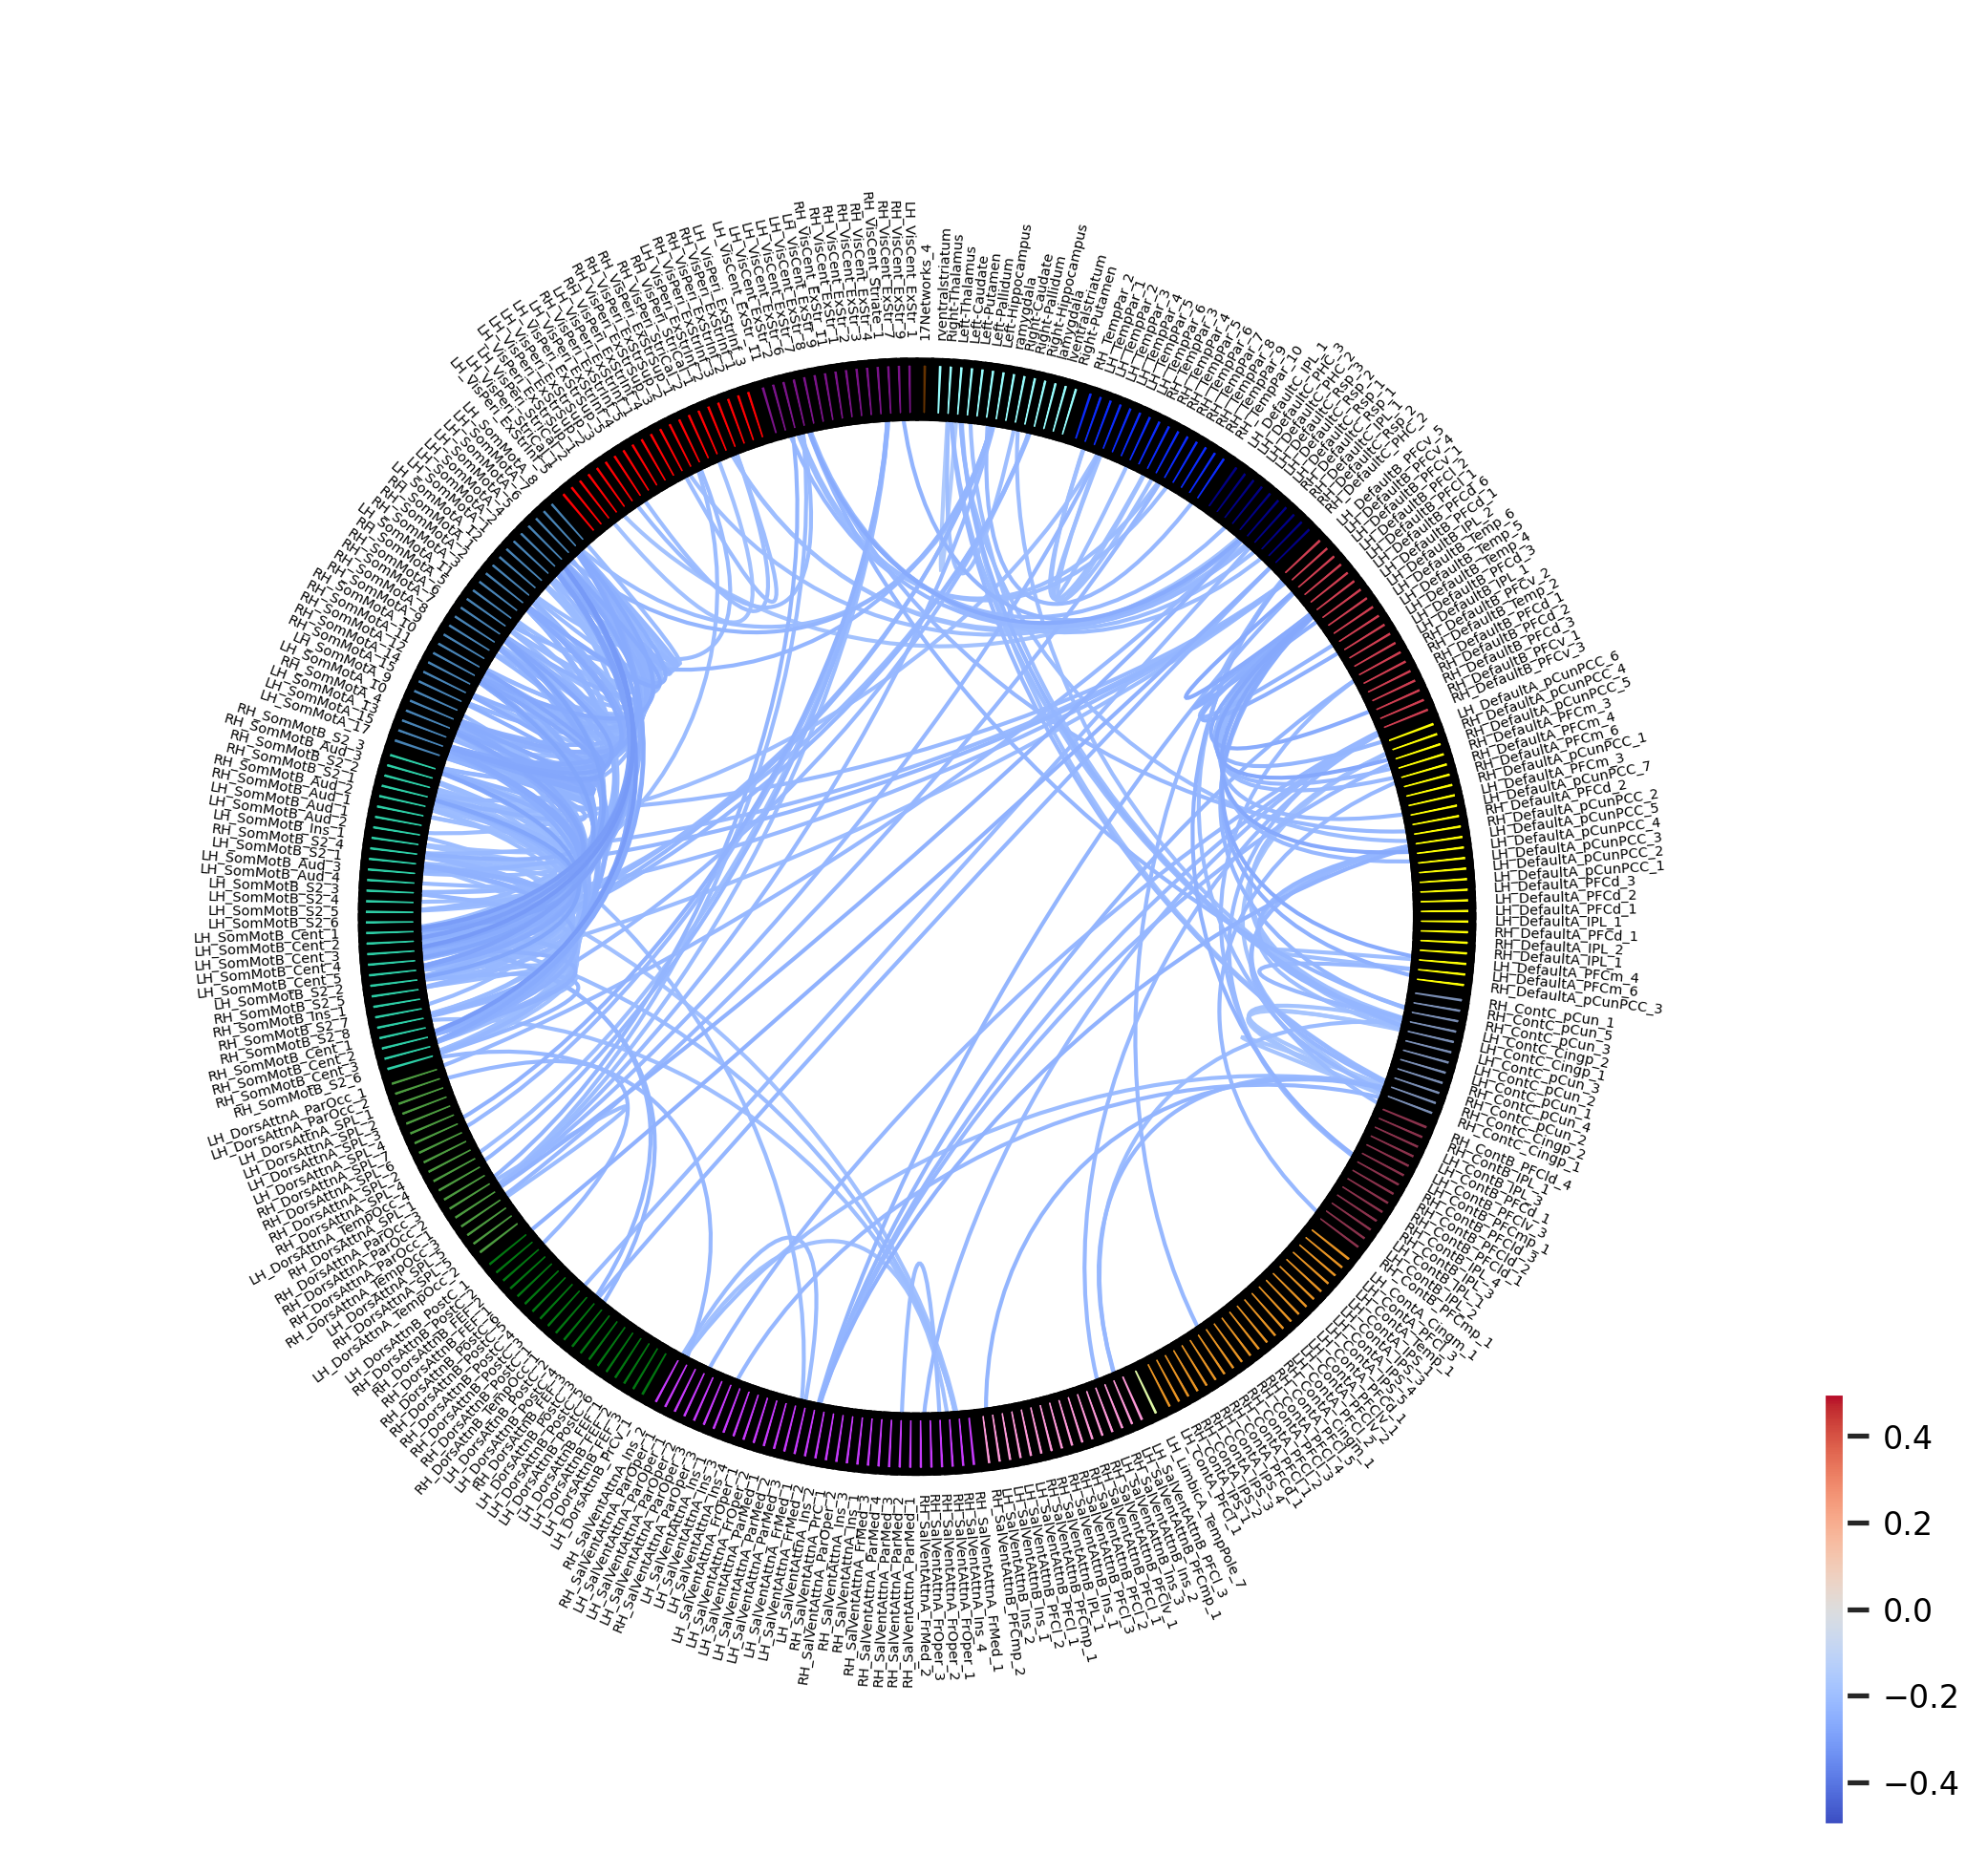

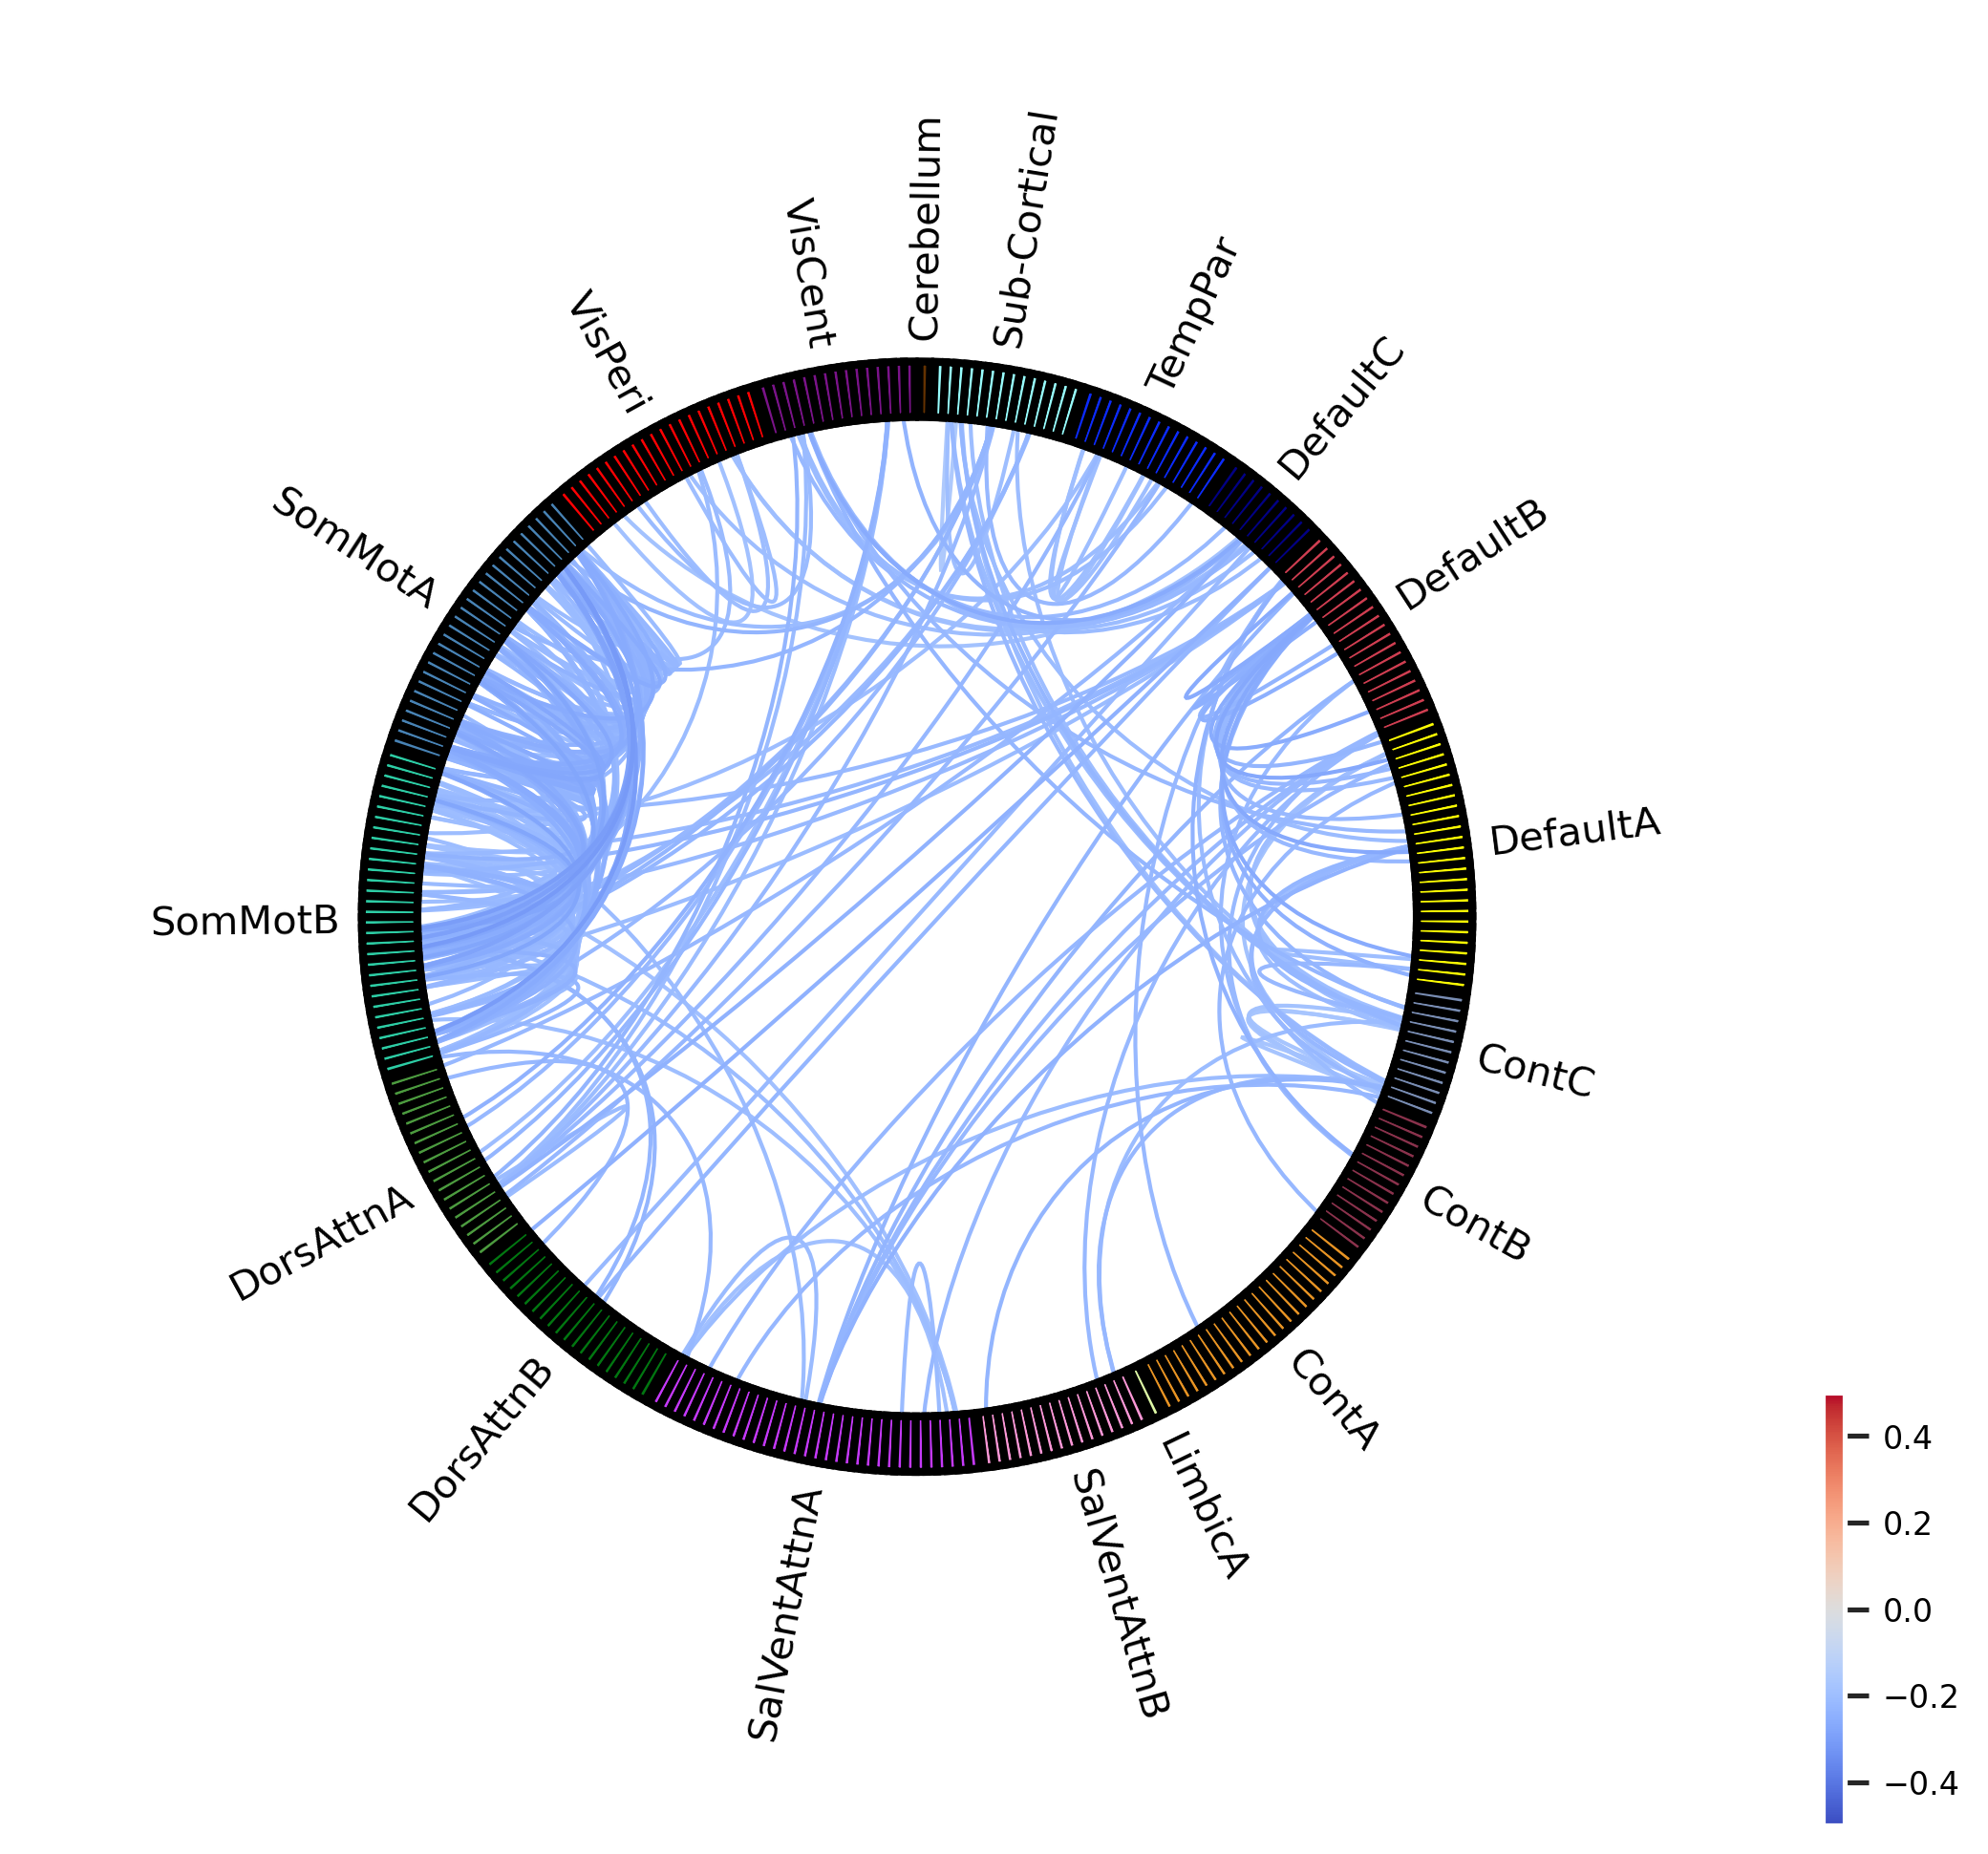

In [437]:
result_dirs = sorted(glob.glob(os.path.join(UNIVARIATE_RESULTS_DIR, '*', '*')))

for i_r, result_dir in enumerate(result_dirs):
    
    result_path = os.path.join(result_dir, 'LME_results.csv')
    
    analysis_label = result_path.split('/')[-3]
    analysis_info_string = result_path.split('/')[-2]
    
    age_group = analysis_info_string.split('CLF_')[-1].split('_SAMPLES')[0]
    feature_set = analysis_info_string.split('SAMPLES_')[-1].split('_FEATURES')[0]
    
    if 'FILTER' in analysis_info_string:
        filter_str = analysis_info_string.split('FEATURES_')[-1].split('_FILTER')[0]
    else:
        filter_str = ''
        
    if feature_set != 'ROI-to-ROI-FC':
        continue
    
    # Focus on sensitivity analysis for now
    if ('4b_Sensitivity_Analysis_matched_age_sex_FD' not in analysis_label):
        continue    
        
#     if ('pediatric' not in age_group):
#         continue
    
    if os.path.exists(result_path):
        
        print(analysis_label, filter_str, age_group, feature_set)
        
        # Parse info
        df = pd.read_csv(result_path)
        
        # Restructure statistics into correlation matrix
        d_mat = tril_vec_to_mat(df.d, n_ROIs, fill_diag=99)
        p_FDR_corrected_mat = tril_vec_to_mat(df.p_FDR_corrected, n_ROIs, fill_diag=1)

        # Create different thresholding masks
        p_FDR_thresh_mask = p_FDR_corrected_mat >= qFDR
        
        # Add upper triangular to thresholding mask so this will be ignored
        p_FDR_thresh_mask[np.triu_indices(n_ROIs)] = True

        # Mask unsignificant connections
        con = d_mat.copy()
        con[p_FDR_thresh_mask] = 0

        # This is number of significant connections (divided by two for lower triangular)
        N_lines = int(np.sum(con != 0))
        print(N_lines)
        print()
        
        if N_lines > 0:
        
            # Plot connectivity_circle with full ROI labels for Supplement
            output_basename = os.path.join(result_dir, 'LME_d_FDR_circular_full_labels')
            plot_ROI_FC_connectivity_circle(con, label_names, N_lines, node_angles, 
                                            roi_FC_network_colors, output_basename, fontsize_names=3.5)

            # Plot connectivity_circle with network labels for main text
            output_basename = os.path.join(result_dir, 'LME_d_FDR_circular_network_labels')
            plot_ROI_FC_connectivity_circle(con, network_labels_circular_plot, N_lines, node_angles, 
                                            roi_FC_network_colors, output_basename, fontsize_names=10) 

In [ ]:
# For within patient subanalyses create p uncorrected plots

result_dirs = sorted(glob.glob(os.path.join(UNIVARIATE_RESULTS_DIR, '*', '*')))

for i_r, result_dir in enumerate(result_dirs):
    
    result_path = os.path.join(result_dir, 'LME_results.csv')
    
    analysis_label = result_path.split('/')[-3]
    analysis_info_string = result_path.split('/')[-2]
    
    age_group = analysis_info_string.split('CLF_')[-1].split('_SAMPLES')[0]
    feature_set = analysis_info_string.split('SAMPLES_')[-1].split('_FEATURES')[0]
    
    if 'FILTER' in analysis_info_string:
        filter_str = analysis_info_string.split('FEATURES_')[-1].split('_FILTER')[0]
    else:
        filter_str = ''
        
    if feature_set != 'ROI-to-ROI-FC':
        continue
        
    # Focus on pediatric
    if ('5_Eyes_Paradigm_Subgroup_Analyses' not in analysis_label):
        continue    
        
#     if ('pediatric' not in age_group):
#         continue
    
    if os.path.exists(result_path):
        
        print(analysis_label, filter_str, age_group, feature_set)
        
        # Parse info
        df = pd.read_csv(result_path)
        
        # Restructure statistics into correlation matrix
        d_mat = tril_vec_to_mat(df.d, n_ROIs, fill_diag=99)

        p_uncorrected_mat = tril_vec_to_mat(df.p_value, n_ROIs, fill_diag=1)

        # Create different thresholding masks
        p_unc_thresh_mask = p_uncorrected_mat >= 0.05
        
        # Add upper triangular to thresholding mask so this will be ignored
        p_unc_thresh_mask[np.triu_indices(n_ROIs)] = True

        # Mask unsignificant connections
        con = d_mat.copy()
        con[p_unc_thresh_mask] = 0

        # This is number of significant connections (divided by two for lower triangular)
        N_lines = int(np.sum(con != 0))
        print(N_lines)
        print()
        
        if N_lines > 0:
        
            # Plot connectivity_circle with full ROI labels for Supplement
            output_basename = os.path.join(result_dir, 'LME_d_uncorrected_circular_full_labels')
            plot_ROI_FC_connectivity_circle(con, label_names, N_lines, node_angles, 
                                            roi_FC_network_colors, output_basename, fontsize_names=3.5)

            # Plot connectivity_circle with network labels for main text
            output_basename = os.path.join(result_dir, 'LME_d_uncorrected_circular_network_labels')
            plot_ROI_FC_connectivity_circle(con, network_labels_circular_plot, N_lines, node_angles, 
                                            roi_FC_network_colors, output_basename, fontsize_names=10) 